In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('bmh')
plt.rc('text', usetex=True)
%matplotlib inline
from numba import jit

from time import time


import multiprocessing as mp

from scipy.interpolate import RectBivariateSpline

from ipywidgets import FloatProgress
from IPython.display import display

#from doublegyre import velocity_field

from numerical_integrators.single_step import euler, rk2, rk3, rk4

from numerical_integrators.adaptive_step import rkdp54, rkdp87

# Nødvendige for å opprette mapper om de ikke allerede eksisterer:
# (For lagring av advekterte tilstander)
import os
import errno

In [2]:
def ensure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [3]:
fixed_step_integrators = set(['euler', 'rk2', 'rk3', 'rk4'])

In [4]:
def grid_of_particles(Nx, Ny = None, wx = 2, wy = 1):
    if Ny == None:
        Ny = np.round(Nx*wy/wx).astype(int)
        
    dx = wx / Nx
    dy = wy / Ny
    
    x0 = (np.arange(Nx) + 1/2) * dx
    y0 = (np.arange(Ny) + 1/2) * dy
    
    y, x = np.meshgrid(y0, x0)
    
    #pos = np.empty((2, Nx*Ny))
    
    #for j in range(Ny):
    #    pos[0,j*Nx:(j+1)*Nx] = x0
    #    pos[1,j*Nx:(j+1)*Nx] = y0[j]
    
    return np.array([x,y])
    
@jit(nopython=True)                                                            
def doublegyre(t, x, A, e, w):                                              
    a = e * np.sin(w*t)                                                         
    b = 1 - 2*e*np.sin(w*t)                                                     
    f = a*x[0,:]**2 + b*x[0,:]                                                  
    v = np.empty(x.shape)                                                   
    v[0,:] = -np.pi*A*np.sin(np.pi*f)*np.cos(np.pi*x[1,:]) # x-component        
    v[1,:] = np.pi*A*np.cos(np.pi*f)*np.sin(np.pi*x[1,:])*(2*a*x[0,:] + b) # y-component
    return v 
    
# Function wrapper to pass to the integrator.
# x is a two-component vector, x = [x_coord, y_coord]
@jit(nopython=True)
def vel(t, x):
    # Parameters of the velocity field:
    A = 0.1         # A
    e = 0.1         # epsilon
    w = 2*np.pi/10  # omega
    return doublegyre(t,x,A,e,w)

In [5]:
def endpoints(t_min, t_max, pos, h, integrator, deriv, atol = None, rtol = None):
    if integrator.__name__ in fixed_step_integrators:
        return __endpoints_fixed(t_min, t_max, pos, h, integrator, deriv)
    else:
        return __endpoints_adaptive(t_min, t_max, pos, h, integrator, deriv, atol, rtol)
    
def _endpoints_fixed(t_min, t_max, pos, h, integrator, deriv):
    t = t_min
    for j in range(np.ceil((t_max - t_min)/h).astype(int)):
        t, pos, h = integrator(t, pos, h, deriv)
    return pos

def __endpoints_fixed(t_min, t_max, pos, h, integrator, deriv, n_proc = 4):
    
    part = np.floor(np.size(pos,1) / n_proc).astype(int)
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    
    processlist = [mp.Process(target = __endpoints_fixed_slice, 
                             args = (t_min, t_max, 
                                    pos[:, j*part:-1 if j + 1 == n_proc else (j+1)*part], 
                                    h, integrator, deriv, queuelist[j])) for j in range(n_proc)]

    for process in processlist:
        process.start()
        
    for j, queue in enumerate(queuelist):
        pos[:, j*part:-1 if j+1 == n_proc else (j+1)*part] = queue.get()
    
    for process in processlist:
        process.join()
    
    return pos
    
def __endpoints_fixed_slice(t_min, t_max, pos, h, integrator, deriv, q):
    t = t_min
    for j in range(np.ceil((t_max - t_min)/h).astype(int)):
        t, pos, h = integrator(t, pos, h, deriv)
    q.put(pos)

def __endpoints_adaptive(t_min, t_max, pos, h, integrator, deriv, atol, rtol, n_proc = 4):
    part = np.floor(np.size(pos,1) / n_proc).astype(int)
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    
    processlist = [mp.Process(target = __endpoints_adaptive_slice, 
                             args = (t_min, t_max, 
                                    pos[:, j*part:-1 if j + 1 == n_proc else (j+1)*part], 
                                    h, integrator, deriv, queuelist[j], atol, rtol)) for j in range(n_proc)]

    for process in processlist:
        process.start()
        
    for j, queue in enumerate(queuelist):
        pos[:, j*part:-1 if j+1 == n_proc else (j+1)*part] = queue.get()
    
    for process in processlist:
        process.join()
    
    return pos

def __endpoints_adaptive_slice(t_min, t_max, pos, h, integrator, deriv, q, atol, rtol):
    t = np.ones(np.shape(pos[0]))*t_min
    h = np.ones(np.shape(t))*h
    
    while np.any(np.less(t, t_max)):
        h = np.minimum(h, t_max - t)
        t, pos, h = integrator(t, pos, h, deriv, atol, rtol)
        
    q.put(pos)

# Step 0: Check that the transport goes as planned

In [6]:
Nx = 200
pos_init = grid_of_particles(Nx)

integrator = rk4

# Transport parameters:
t_min = 0
t_max = 5
h = 0.1

# Loop over grid and update all positions:
tic = time()
pos_fin = endpoints(t_min, t_max, pos_init, h, integrator, vel)
toc = time()

print('Transport took %.3f seconds' % (toc - tic))

Transport took 13.762 seconds


(0, 1)

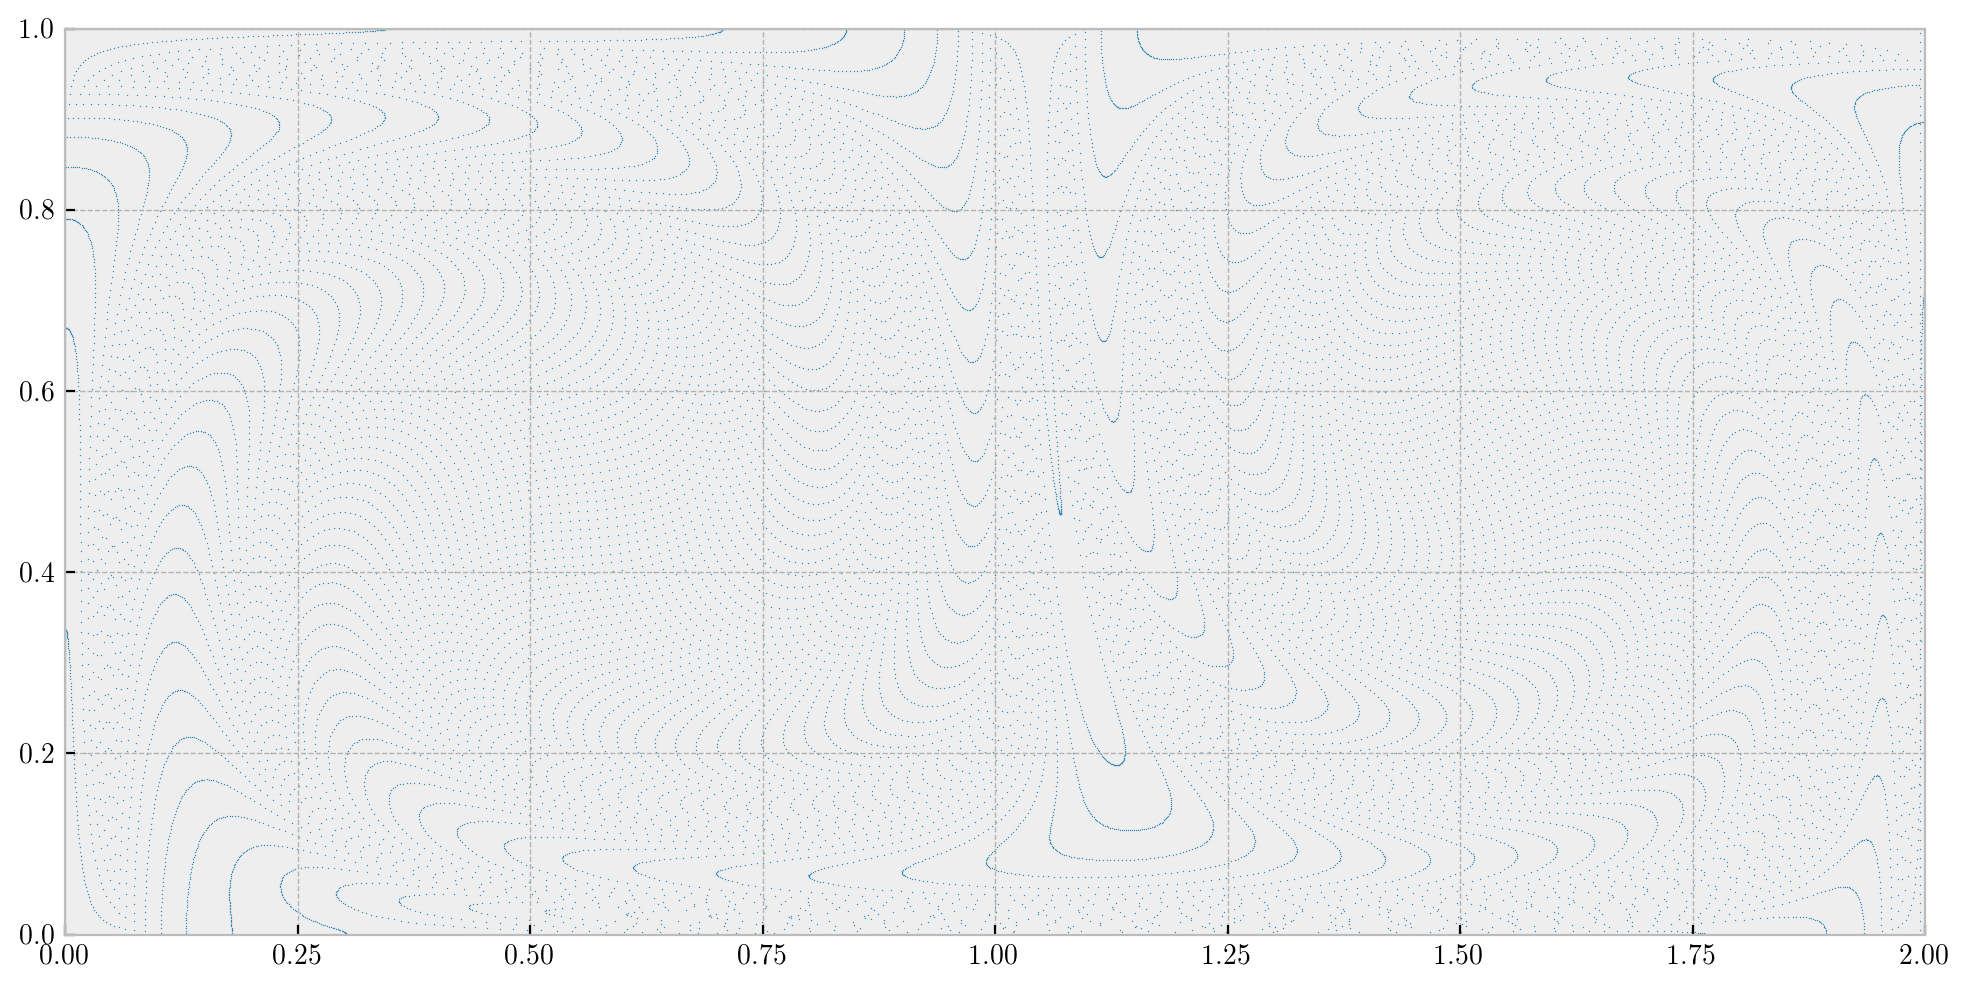

In [7]:
# Make a scatter plot to show grid points:
fig = plt.figure(figsize = (12,6), dpi = 200)
plt.scatter(pos_fin[0,:], pos_fin[1,:], lw = 0, marker = '.', s = 1)
plt.xlim(0, 2)
plt.ylim(0, 1)

# Step 1: Advect lots of particles

### ... including auxiliary grid points for independent improvement to spatial derivatives, following suite

In [8]:
# Choosing integrator:
integrator = rk4

# Create output directory for advected positions, if it does not already exist:
ensure_path_exists('advected_end_positions/{}'.format(integrator.__name__))

# Particle count in the x- and y-directions:
Nx = 1000
Ny = 500

# ----
#      Main grid:
# ----
pos_init = grid_of_particles(Nx, Ny)

# Grid parameters, original grid:
dx = pos_init[0,-1,0] - pos_init[0,-2,0]
dy = pos_init[1,0,-1] - pos_init[1, 0, -2]

# ----
#      Transport parameters:
# ----

t_min = 0.
t_max = 20.
h = 0.05      # <--- Timestep, for fixed stepsize methods
tol = 1e-6    # <--- Tolerance, for adaptive stepsize methods 

# ----
#      Auxiliary grid spacing:
# ----

# Must be smaller (i.e., less than half) of that of the original grid
d = np.minimum(1e-5, dx*1e-2)

In [9]:
# If advection has already been performed previously, 
# load saved state.

# For fixed step integrators, the tolerance plays no role, and its value is thus not
# stored in the file names; similarly, the (initial) step length plays no _real_
# role for adaptive step size integrators, and is thus not stored in file names.

try:
    if integrator.__name__ in fixed_step_integrators:
        pos_fin = np.load('advected_end_positions/{}/main_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h))
        right_fin = np.load('advected_end_positions/{}/right_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h))
        left_fin = np.load('advected_end_positions/{}/left_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h))
        above_fin = np.load('advected_end_positions/{}/above_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h))
        beneath_fin = np.load('advected_end_positions/{}/beneath_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h))
    else:
        pos_fin = np.load('advected_end_positions/{}/main_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol))
        right_fin = np.load('advected_end_positions/{}/right_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol))
        left_fin = np.load('advected_end_positions/{}/left_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol))
        above_fin = np.load('advected_end_positions/{}/above_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol))
        beneath_fin = np.load('advected_end_positions/{}/beneath_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol))
    print('Configuration found! Advection not neccesary in this instance.')
except IOError:
    tic = time()
    pos_fin = endpoints(t_min, t_max, pos_init, h, integrator, vel, tol, tol)
    above_fin = endpoints(t_min, t_max, pos_init + np.array([0,d]).reshape(2,1,1), h, integrator, vel, tol, tol)
    beneath_fin = endpoints(t_min, t_max, pos_init + np.array([0,-d]).reshape(2,1,1), h, integrator, vel, tol,tol)

    right_fin = endpoints(t_min, t_max, pos_init + np.array([d,0]).reshape(2,1,1), h, integrator, vel, tol,tol)
    left_fin = endpoints(t_min, t_max, pos_init + np.array([-d,0]).reshape(2,1,1), h, integrator, vel,tol,tol)
    toc = time()
    print('Configuration not found! Advection was neccessary, elapsed time in integrating: {} seconds'.format(toc - tic))
    
    if integrator.__name__ in fixed_step_integrators:
        np.save('advected_end_positions/{}/main_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h), pos_fin)
        np.save('advected_end_positions/{}/right_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h), right_fin)
        np.save('advected_end_positions/{}/left_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h), left_fin)
        np.save('advected_end_positions/{}/above_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h), above_fin)
        np.save('advected_end_positions/{}/beneath_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h), beneath_fin)
    else:
        np.save('advected_end_positions/{}/main_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol), pos_fin)
        np.save('advected_end_positions/{}/right_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol), right_fin)
        np.save('advected_end_positions/{}/left_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol), left_fin)
        np.save('advected_end_positions/{}/above_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol), above_fin)
        np.save('advected_end_positions/{}/beneath_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol), beneath_fin)
    
    print('Configuration now stored. Advection will not be necessary the next time the same parameters are used!')
    

Configuration found! Advection not neccesary in this instance.


# Step 2: Calculate derivatives of flow maps

### ... partly by use of auxiliary grid points

In [10]:
# [0,0]-component: dx/dx
# [0,1]-component: dx/dy
# [1,0]-component: dy/dx
# [1,1]-component: dy/dy

dF = np.empty((2, 2, Nx, Ny))
dF_a = np.copy(dF)

# Derivatives for auxiliary array:
# Centered differencing throughout
# dx/dx
dF_a[0,0,:,:] = (right_fin[0] - left_fin[0]) / (2*d)
# dx/dy
dF_a[0,1,:,:] = (above_fin[0] - beneath_fin[0]) / (2*d)
# dy/dx
dF_a[1,0,:,:] = (right_fin[1] - left_fin[1]) / (2*d)
# dy/dy
dF_a[1,1,:,:] = (above_fin[1] - beneath_fin[1]) / (2*d)

# Derivatives for main array:

# dx/dx
dF[0,0,0,:]    = (-3*pos_fin[0,0,:] + 4*pos_fin[0,1,:] - 2*pos_fin[0,2,:]) / (2*dx)   # 2nd order accurate forward differencing
dF[0,0,1:-2,:] = (pos_fin[0,2:-1,:] - pos_fin[0,0:-3,:]) / (2*dx)                     # Centered differencing
dF[0,0,-1,:]   = (3*pos_fin[0,-1,:] - 4*pos_fin[0,-2,:] + 2*pos_fin[0,-3,:]) / (2*dx) # 2nd order accurate backward differencing

# dx/dy
dF[0,1,:,0]    = (-3*pos_fin[0,:,0] + 4*pos_fin[0,:,1] - 2*pos_fin[0,:,2]) / (2*dy)   # 2nd order accurate forward differencing
dF[0,1,:,1:-2] = (pos_fin[0,:,2:-1] - pos_fin[0,:,0:-3]) / (2*dy)                     # Centered differencing
dF[0,1,:,-1]   = (3*pos_fin[0,:,-1] - 4*pos_fin[0,:,-2] + 2*pos_fin[0,:,-3]) / (2*dy) # 2nd order accurate backward differencing

# dy/dx
dF[1,0,0,:]    = (-3*pos_fin[1,0,:] + 4*pos_fin[1,1,:] - 2*pos_fin[1,2,:]) / (2*dx)   # 2nd order accurate forward differencing
dF[1,0,1:-2,:] = (pos_fin[1,2:-1,:] - pos_fin[1,0:-3,:]) / (2*dx)                     # Centered differencing
dF[1,0,-1,:]   = (3*pos_fin[1,-1,:] - 4*pos_fin[1,-2,:] + 2*pos_fin[1,-3,:]) / (2*dx) # 2nd order accurate backward differencing

# dy/dy
dF[1,1,:,0]    = (-3*pos_fin[1,:,0] + 4*pos_fin[1,:,1] - 2*pos_fin[1,:,2]) / (2*dy)   # 2nd order accurate forward differencing
dF[1,1,:,1:-2] = (pos_fin[1,:,2:-1] - pos_fin[1,:,0:-3]) / (2*dy)                     # Centered differencing
dF[1,1,:,-1]   = (3*pos_fin[1,:,-1] - 4*pos_fin[1,:,-2] + 2*pos_fin[1,:,-3]) / (2*dy) # 2nd order accurate backward differencing


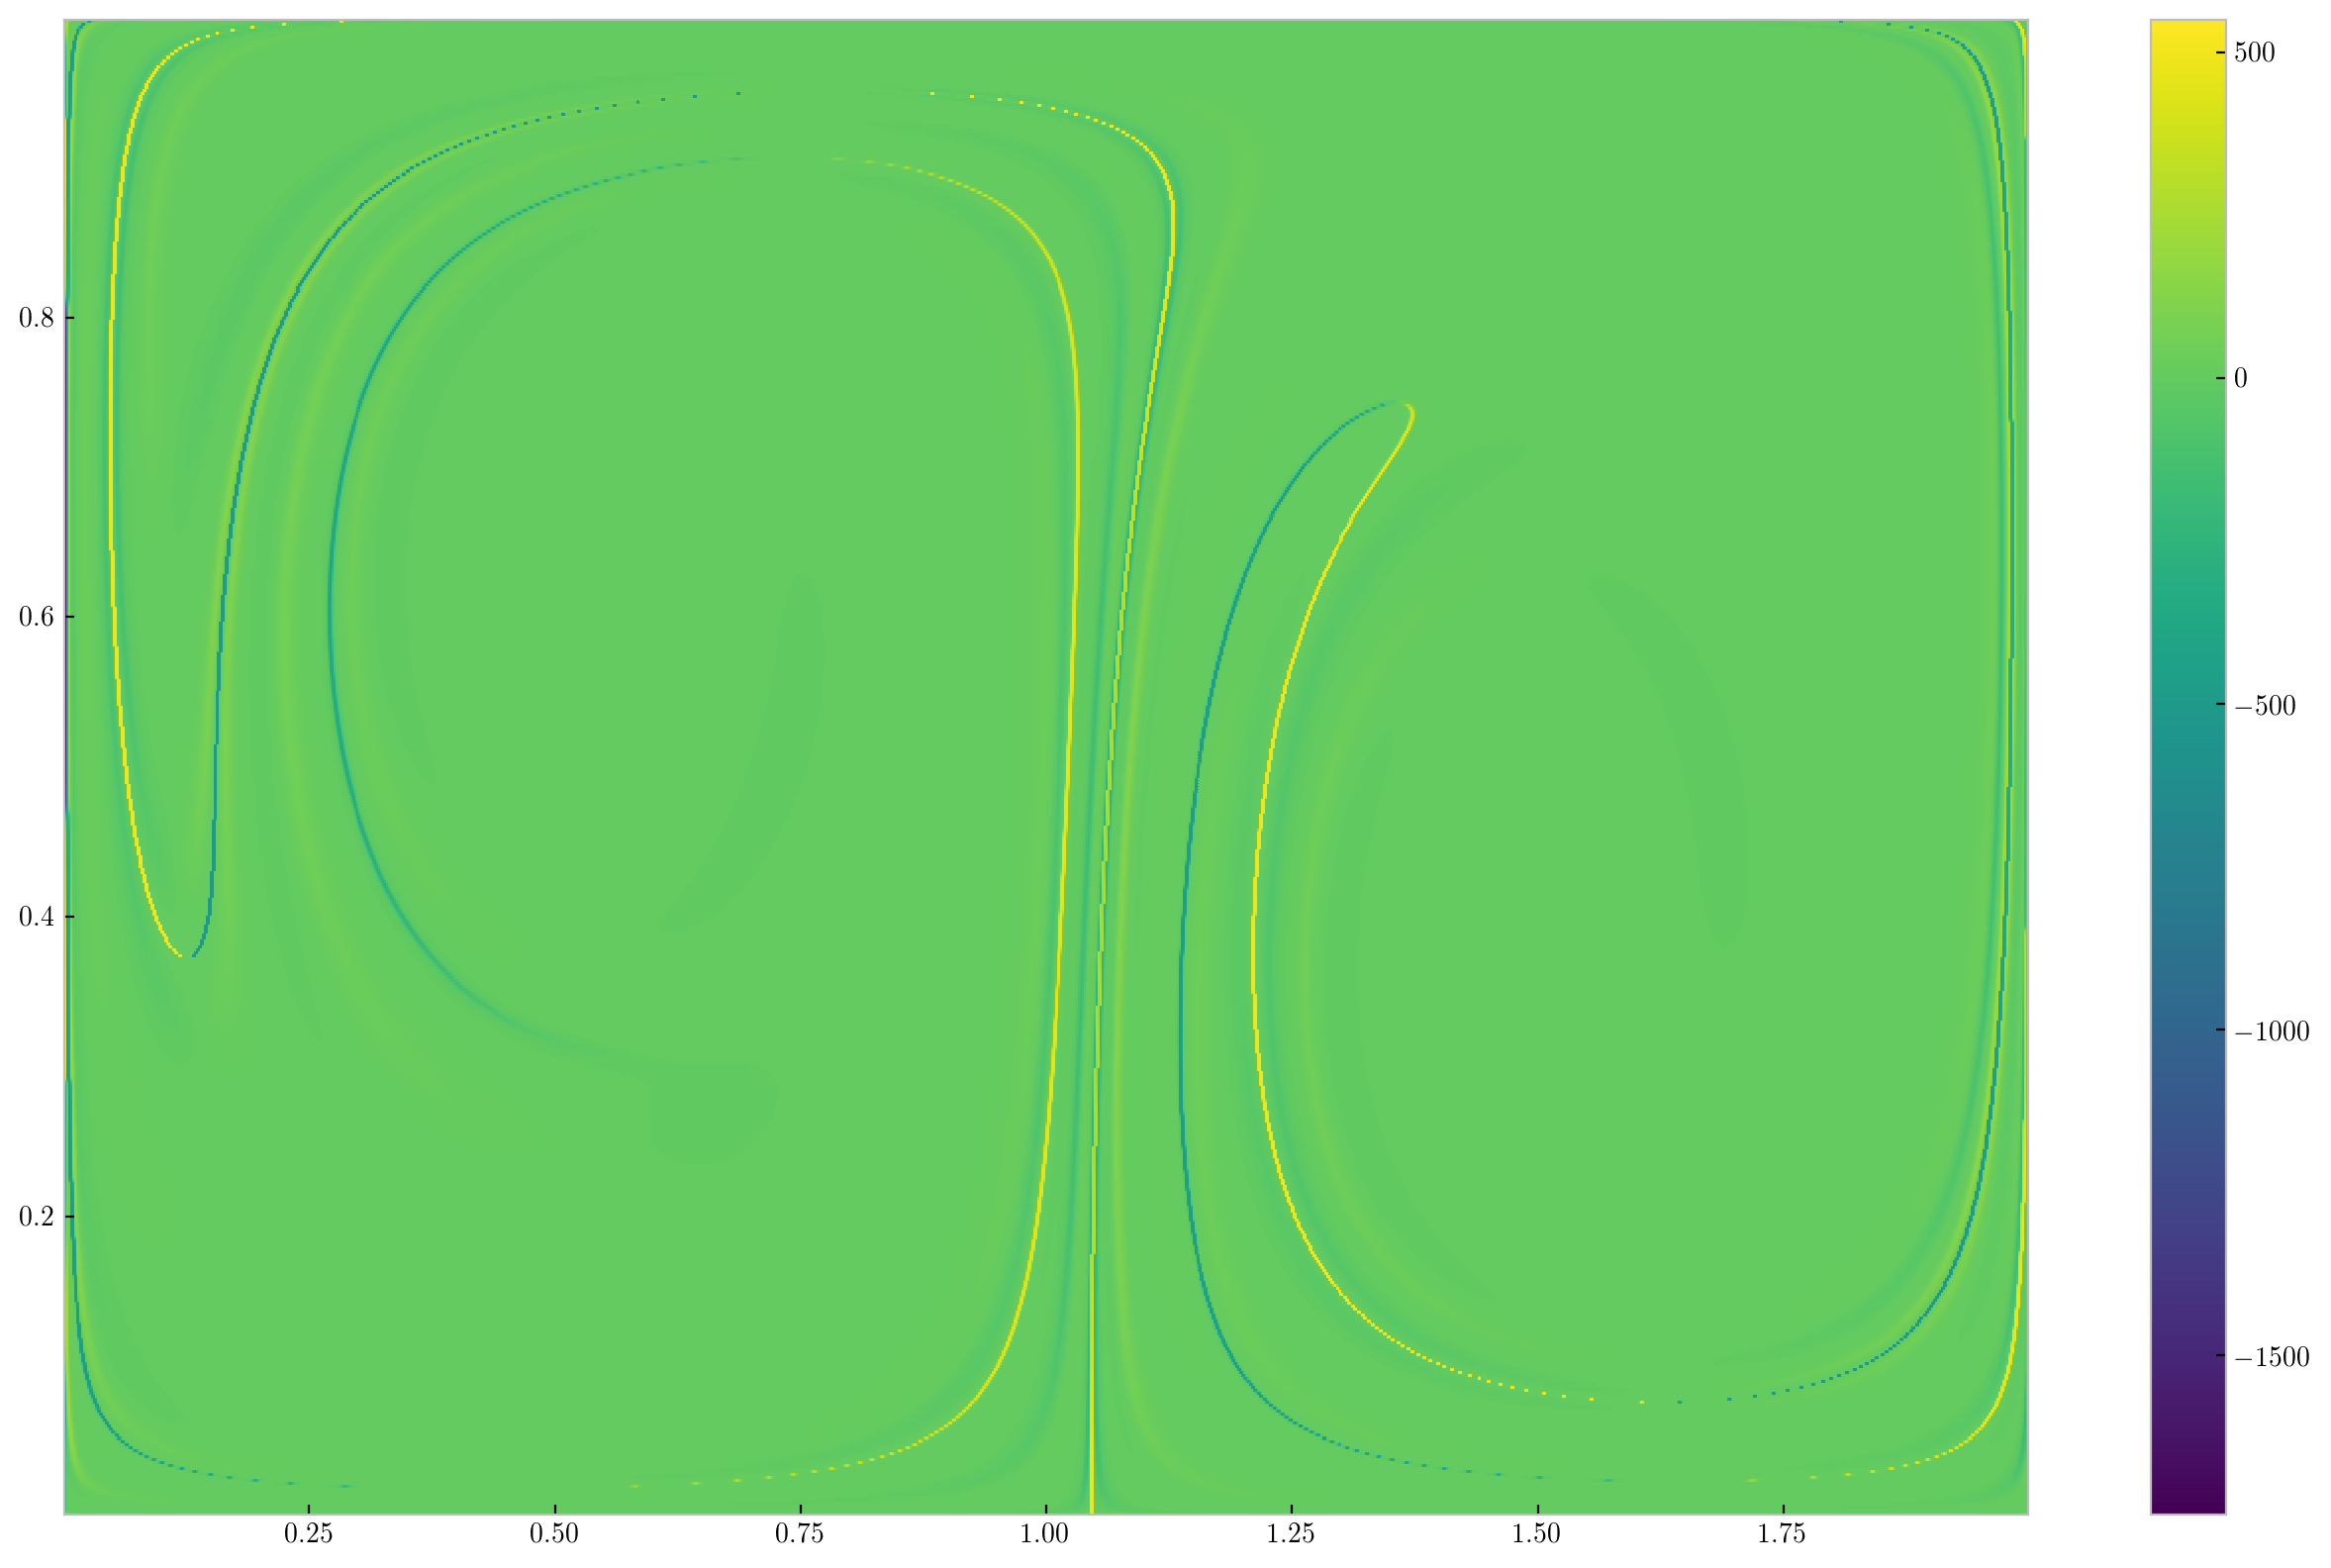

In [11]:
plt.figure(figsize = (16,10), dpi = 200)
mesh = plt.pcolormesh(pos_init[0,:,:], pos_init[1,:,:], dF[0,0,:,:])
plt.colorbar(mesh)


# Step 3: Calculate Cauchy-Green strain tensors

In [12]:
C = np.empty(dF.shape)
C_a = np.empty(dF_a.shape)

assert dF.shape == dF_a.shape

for i in range(dF_a.shape[2]):
    for j in range(dF_a.shape[3]):
        C[:,:,i,j] = np.dot(dF[:,:,i,j].T, dF[:,:,i,j])
        C_a[:,:,i,j] = np.dot(dF_a[:,:,i,j].T, dF_a[:,:,i,j])

# Step 4: Calculate eigenvalues and -vectors of Cauchy-Green strain tensors

In [13]:
evals = np.empty((2, dF_a.shape[2], dF_a.shape[3]))
evecs = np.empty(C.shape)

evals_discard = np.copy(evals)
evecs_discard = np.copy(evecs)

for i in range(dF_a.shape[2]):
    for j in range(dF_a.shape[3]):
        vals, vecs = np.linalg.eigh(C[:,:,i,j])
        vals_a, vecs_a = np.linalg.eigh(C_a[:,:,i,j])
        
        idxvals = vals.argsort()[::-1]
        idxvals_a = vals_a.argsort()[::-1]
        
        evals[:,i,j] = vals[idxvals]
        evecs_discard[:,:,i,j] = vecs[:, idxvals]
        
        evals_discard[:,i,j] = vals_a[idxvals_a] 
        evecs[:,:,i,j] = vecs_a[:,idxvals_a]
        
# Element 0: Largest  eigenvalue and corresponding eigenvector
# Element 1: Smallest -------------------''-------------------

(0, 1)

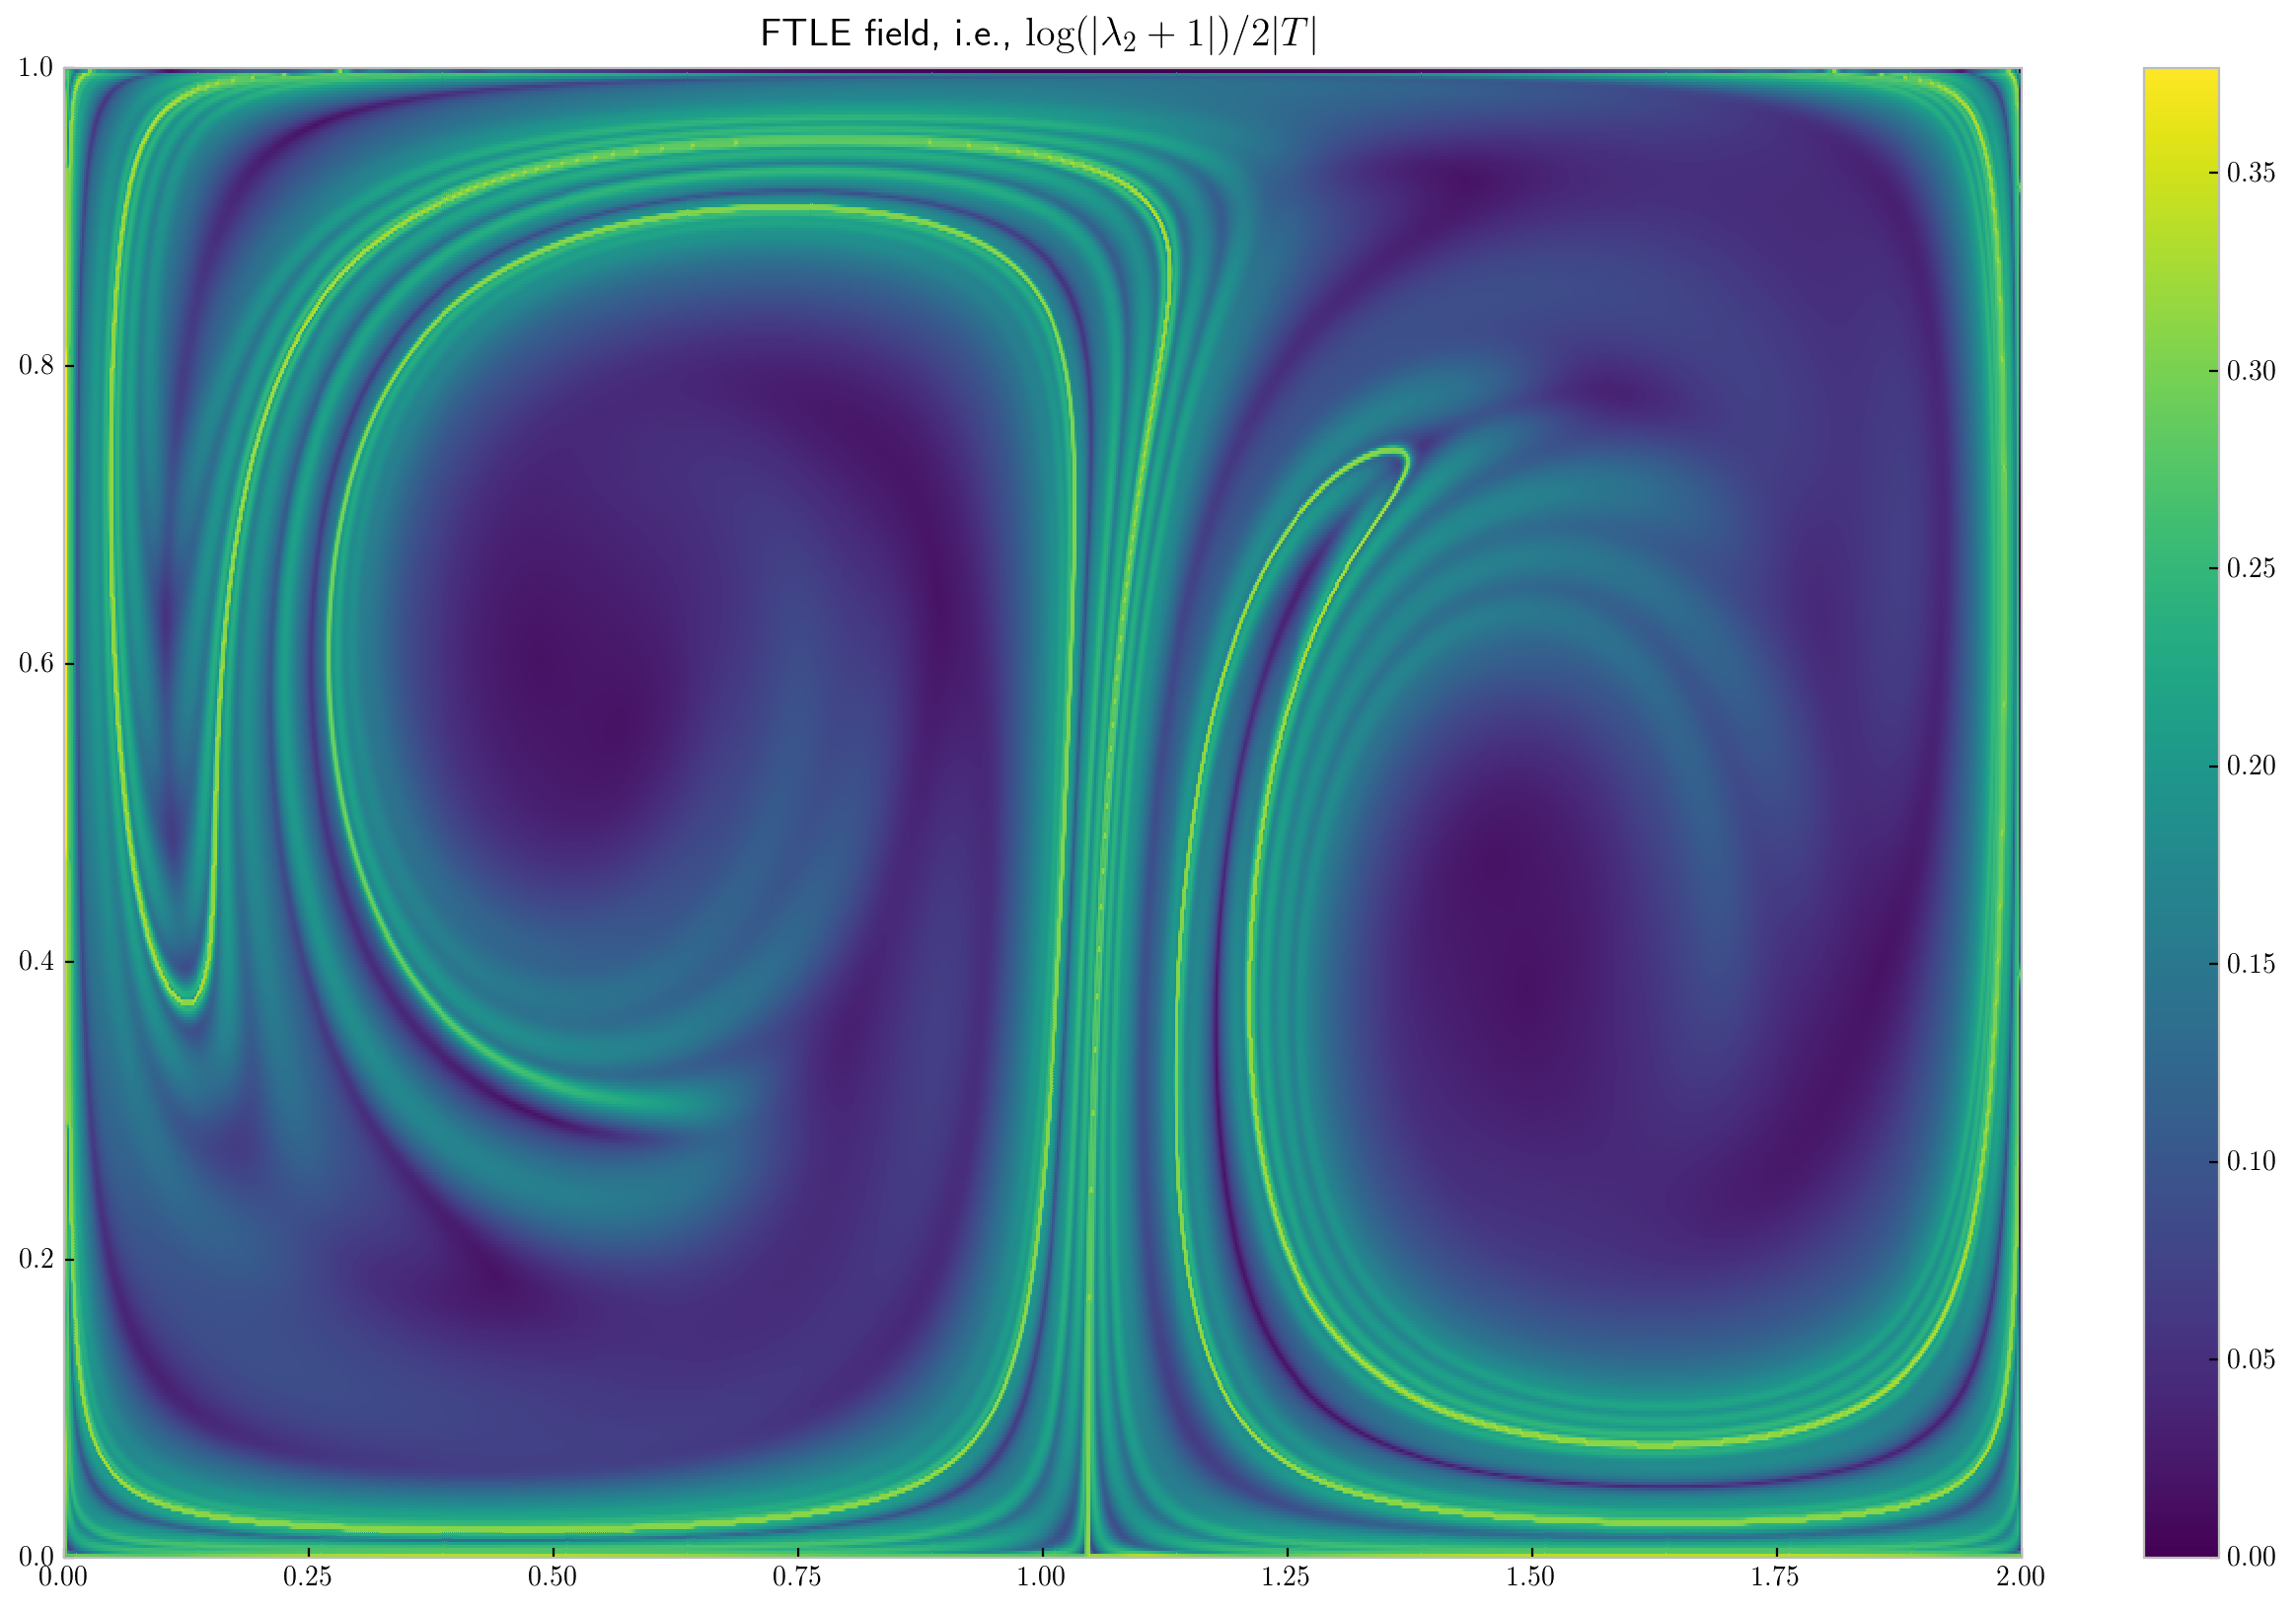

In [14]:
plt.figure(figsize = (16, 10), dpi = 200)
mesh = plt.pcolormesh(pos_init[0,:,:], pos_init[1,:,:], np.log(np.abs(evals[0,:,:] + 1)) / (2*np.abs(t_max - t_min)))
plt.colorbar(mesh)
plt.title(r'FTLE field, i.e., $\log(|\lambda_{2} + 1|) / 2|T|$')
plt.xlim(0,2)
plt.ylim(0,1)

# Step 5: Identify initial points belonging to $\mathcal{G}_{0}$

## i.e., the points for which conditions A and B hold:

### A: $\lambda_{1}(\mathbf{x}_{0}) \neq \lambda_{2}(\mathbf{x}_{0}) > 1 $
### B: $\langle \mathbf{\xi}_{2}(\mathbf{x}_{0}), \nabla^{2} \lambda_2(\mathbf{x}_0) \mathbf{\xi}_2(\mathbf{x}_0) \rangle \leq 0$

In [15]:
A_true = np.logical_and(np.not_equal(evals[0,:,:], evals[1,:,:]), np.greater(evals[0,:,:], 1))

In [16]:
# Find laplacian of largest eigenvector:
d2V = np.empty((Nx, Ny))

# Second derivative, x-direction:
d2V[0,:] = (2*evals[0,0,:] - 5*evals[0,1,:] + 4*evals[0,2,:] - evals[0,3,:])/(dx**2)      # Second order accurate forward difference
d2V[1:-2,:] = (evals[0,2:-1,:] - 2*evals[0,1:-2,:] + evals[0,0:-3,:])/(dx**2)             # Centered difference
d2V[-1,:] = (2*evals[0,-1,:] - 5*evals[0,-2,:] + 4*evals[0,-3,:] - evals[0,-4,:])/(dx**2) # Second order accurate backward difference

# Adding second derivative, y-direction:
d2V[:,0] += (2*evals[0,:,0] - 5*evals[0,:,1] + 4*evals[0,:,2] - evals[0,:,3])/(dy**2)     # Second order accurate forward difference
d2V[:,1:-2] += (evals[0,:,2:-1] - 2*evals[0,:,1:-2] + evals[0,:,0:-3])/(dy**2)            # Centered difference
d2V[:,-1] += (evals[0,:,-1] - 5*evals[0,:,-2] + 4*evals[0,:,-3] - evals[0,:,-4])/(dy**2)  # Second order accurate backward difference

inner = np.sum(evecs[:,0,:,:] * d2V * evecs[:,0,:,:], axis = 0)
B_true = np.less_equal(inner, 0)

In [17]:
# Find laplacian of product between largest eigenvector and -value:
d2VV = np.empty((2, Nx, Ny))

# Second derivative, x-direction:
d2VV[0,0,:] = (2*evals[0,0,:]*evecs[0,0,0,:] - 5*evals[0,1,:]*evecs[0,0,1,:] + 4*evals[0,2,:]*evecs[0,0,2,:] - evals[0,3,:]*evecs[0,0,3,:])/(dx**2)      # Second order accurate forward difference
d2VV[0,1:-2,:] = (evals[0,2:-1,:]*evecs[0,0,2:-1,:] - 2*evals[0,1:-2,:]*evecs[0,0,1:-2,:] + evals[0,0:-3,:]*evecs[0,0,0:-3,:])/(dx**2)             # Centered difference
d2VV[0,-1,:] = (2*evals[0,-1,:]*evecs[0,0,-1,:] - 5*evals[0,-2,:]*evecs[0,0,-2,:] + 4*evals[0,-3,:]*evecs[0,0,-3,:] - evals[0,-4,:]*evecs[0,0,-4,:])/(dx**2) # Second order accurate backward difference

d2VV[1,0,:] = (2*evals[0,0,:]*evecs[1,0,0,:] - 5*evals[0,1,:]*evecs[1,0,1,:] + 4*evals[0,2,:]*evecs[1,0,2,:] - evals[0,3,:]*evecs[1,0,3,:])/(dx**2)      # Second order accurate forward difference
d2VV[1,1:-2,:] = (evals[0,2:-1,:]*evecs[1,0,2:-1,:] - 2*evals[0,1:-2,:]*evecs[1,0,1:-2,:] + evals[0,0:-3,:]*evecs[1,0,0:-3,:])/(dx**2)             # Centered difference
d2VV[1,-1,:] = (2*evals[0,-1,:]*evecs[1,0,-1,:] - 5*evals[0,-2,:]*evecs[1,0,-2,:] + 4*evals[0,-3,:]*evecs[1,0,-3,:] - evals[0,-4,:]*evecs[1,0,-4,:])/(dx**2) # Second order accurate backward difference

# Adding second derivative, y-direction:
d2VV[0,:,0] += (2*evals[0,:,0]*evecs[0,0,:,0] - 5*evals[0,:,1]*evecs[0,0,:,1] + 4*evals[0,:,2]*evecs[0,0,:,2] - evals[0,:,3]*evecs[0,0,:,3])/(dy**2)     # Second order accurate forward difference
d2VV[0,:,1:-2] += (evals[0,:,2:-1]*evecs[0,0,:,2:-1] - 2*evals[0,:,1:-2]*evecs[0,0,:,1:-2] + evals[0,:,0:-3]*evecs[0,0,:,0:-3])/(dy**2)            # Centered difference
d2VV[0,:,-1] += (evals[0,:,-1]*evecs[0,0,:,-1] - 5*evals[0,:,-2]*evecs[0,0,:,-2] + 4*evals[0,:,-3]*evecs[0,0,:,-3] - evals[0,:,-4]*evecs[0,0,:,-4])/(dy**2)  # Second order accurate backward difference

d2VV[1,:,0] += (2*evals[0,:,0]*evecs[1, 0,:,0] - 5*evals[0,:,1]*evecs[1,0,:,1] + 4*evals[0,:,2]*evecs[1,0,:,2] - evals[0,:,3]*evecs[1,0,:,3])/(dy**2)     # Second order accurate forward difference
d2VV[1,:,1:-2] += (evals[0,:,2:-1]*evecs[1,0,:,2:-1] - 2*evals[0,:,1:-2]*evecs[1,0,:,1:-2] + evals[0,:,0:-3]*evecs[1,0,:,0:-3])/(dy**2)            # Centered difference
d2VV[1,:,-1] += (evals[0,:,-1]*evecs[1,0,:,-1] - 5*evals[0,:,-2]*evecs[1,0,:,-2] + 4*evals[0,:,-3]*evecs[1,0,:,-3] - evals[0,:,-4]*evecs[1,0,:,-4])/(dy**2)  # Second order accurate backward difference

inner2 = np.sum(evecs[:,0,:,:] * d2VV, axis = 0)

B_true2 = np.less_equal(inner2, 0)

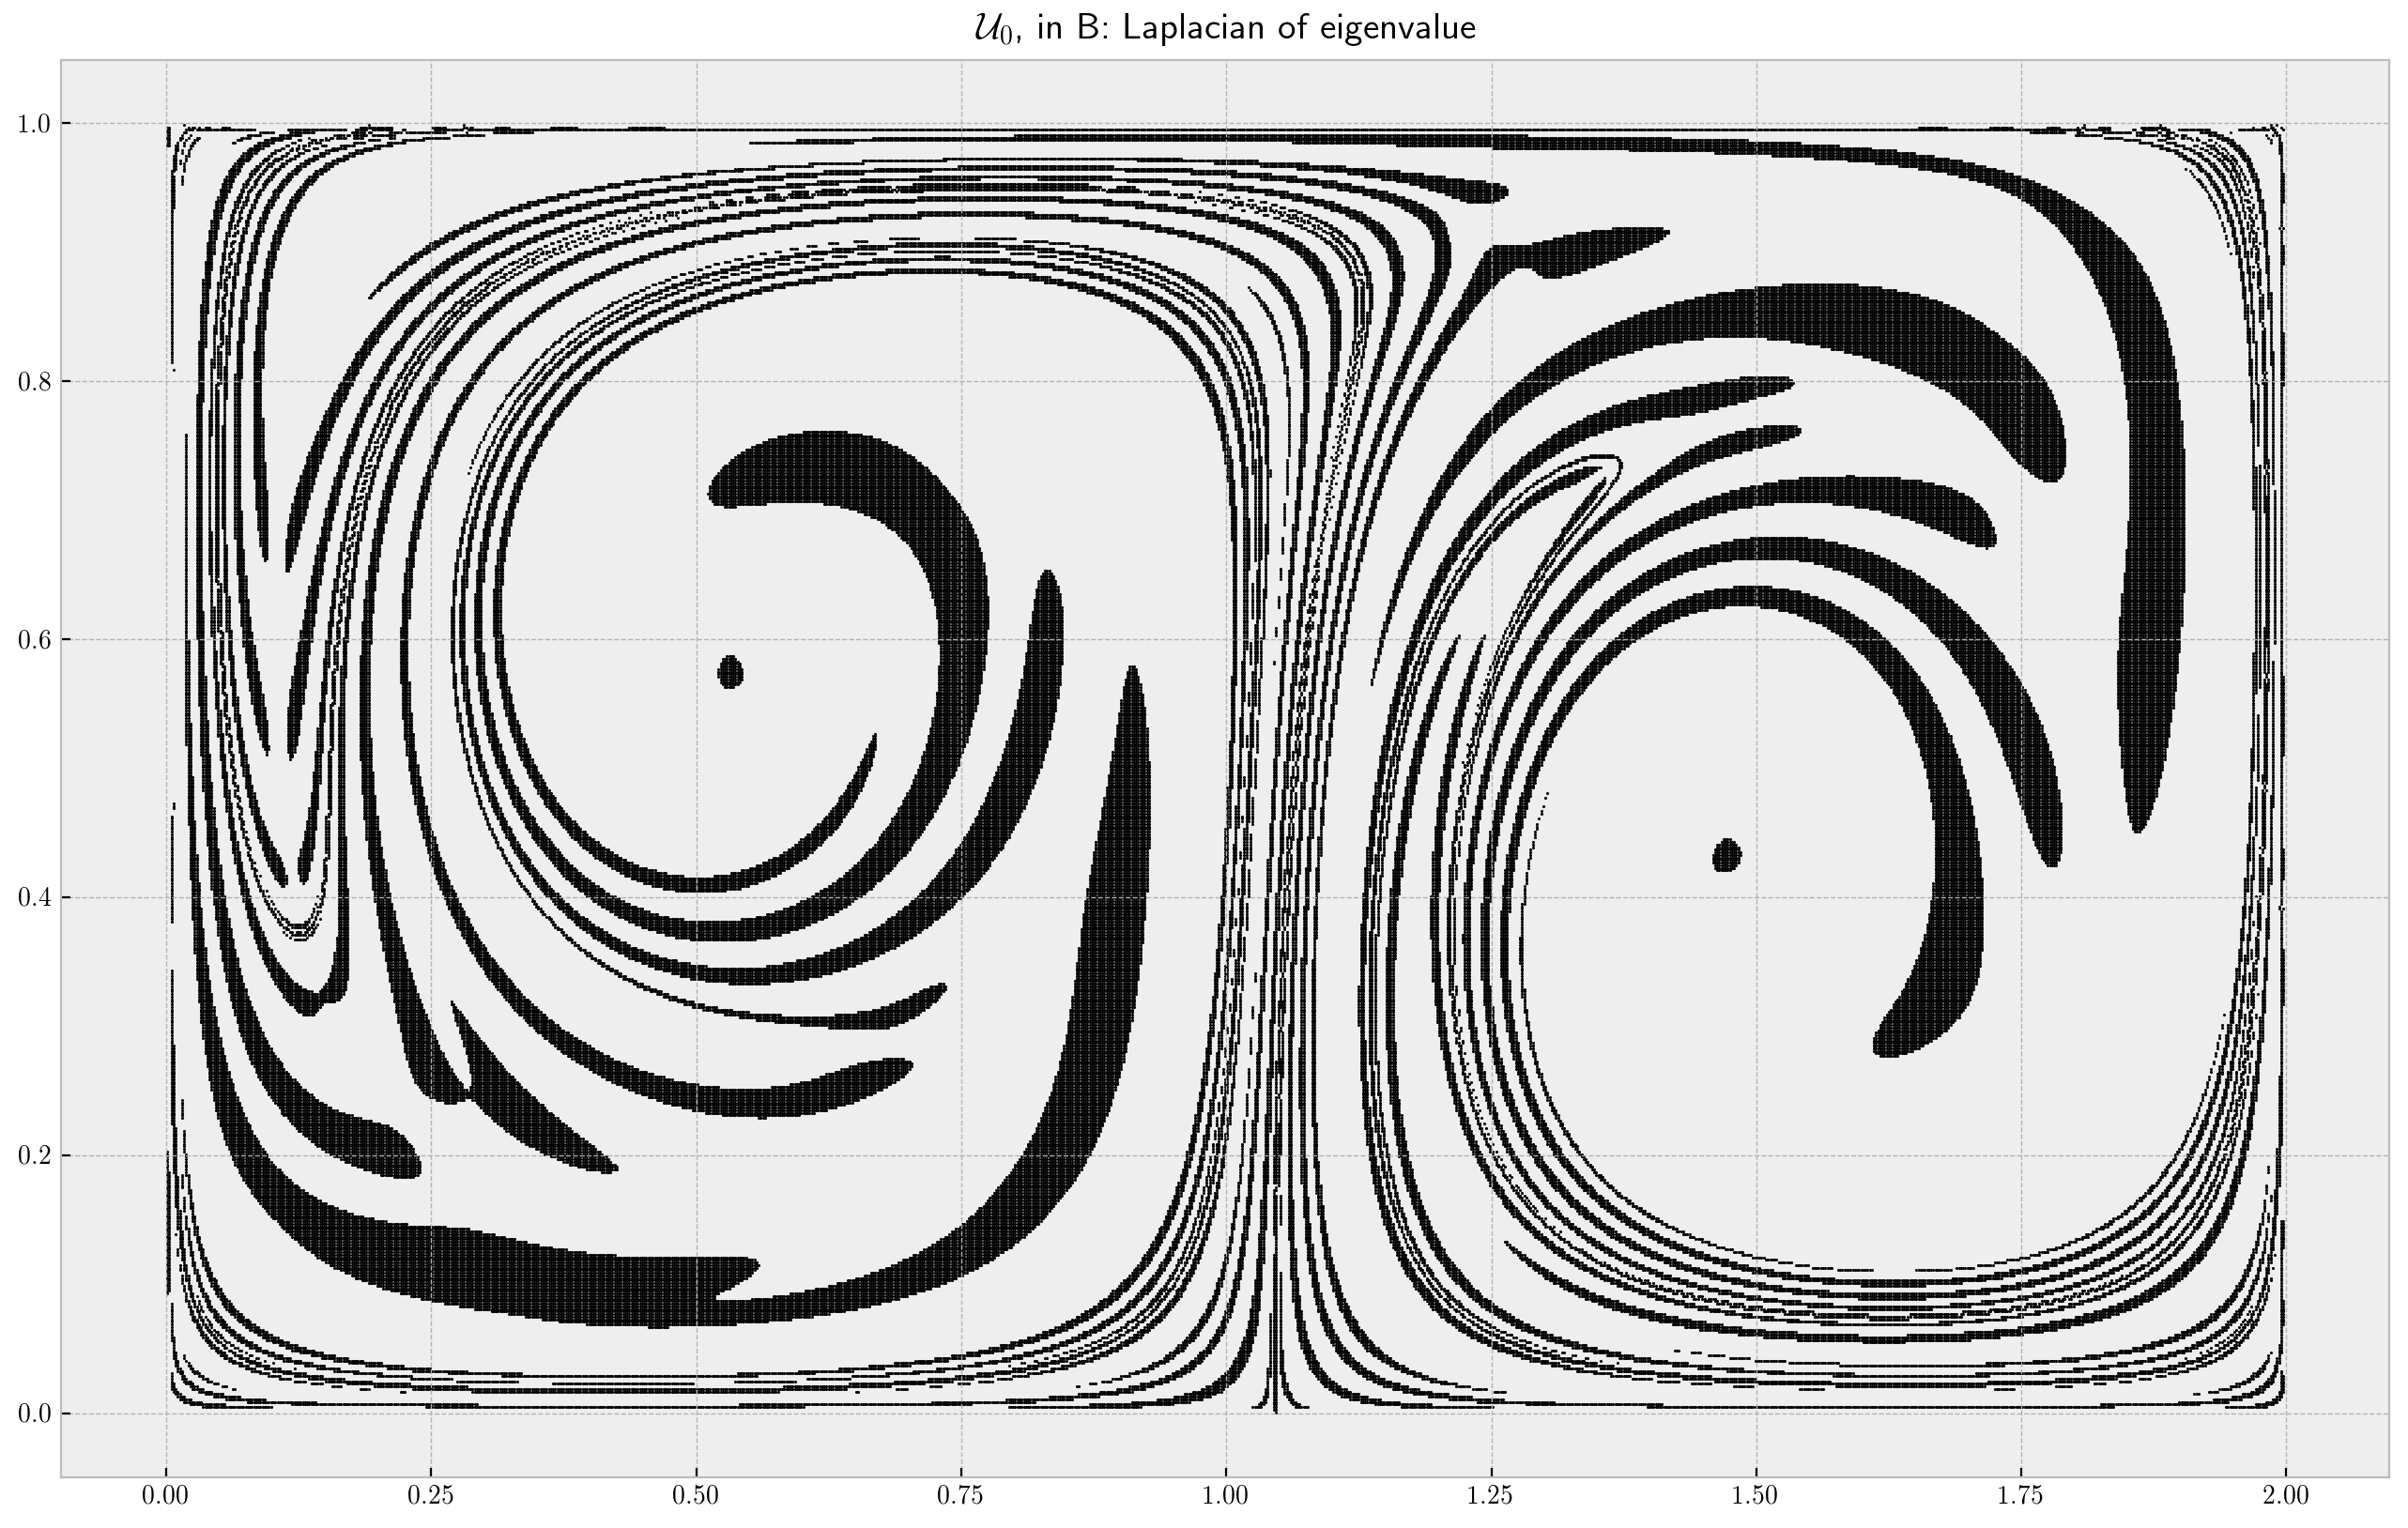

In [18]:
plt.figure(figsize = (16,10), dpi = 200)
plt.scatter(pos_init[0,np.logical_and(A_true,B_true)], pos_init[1,np.logical_and(A_true,B_true)], lw = 0, marker = '.', s = 5, color = 'k')
plt.title(r'$\mathcal{U}_{0}$, in B: Laplacian of eigenvalue')

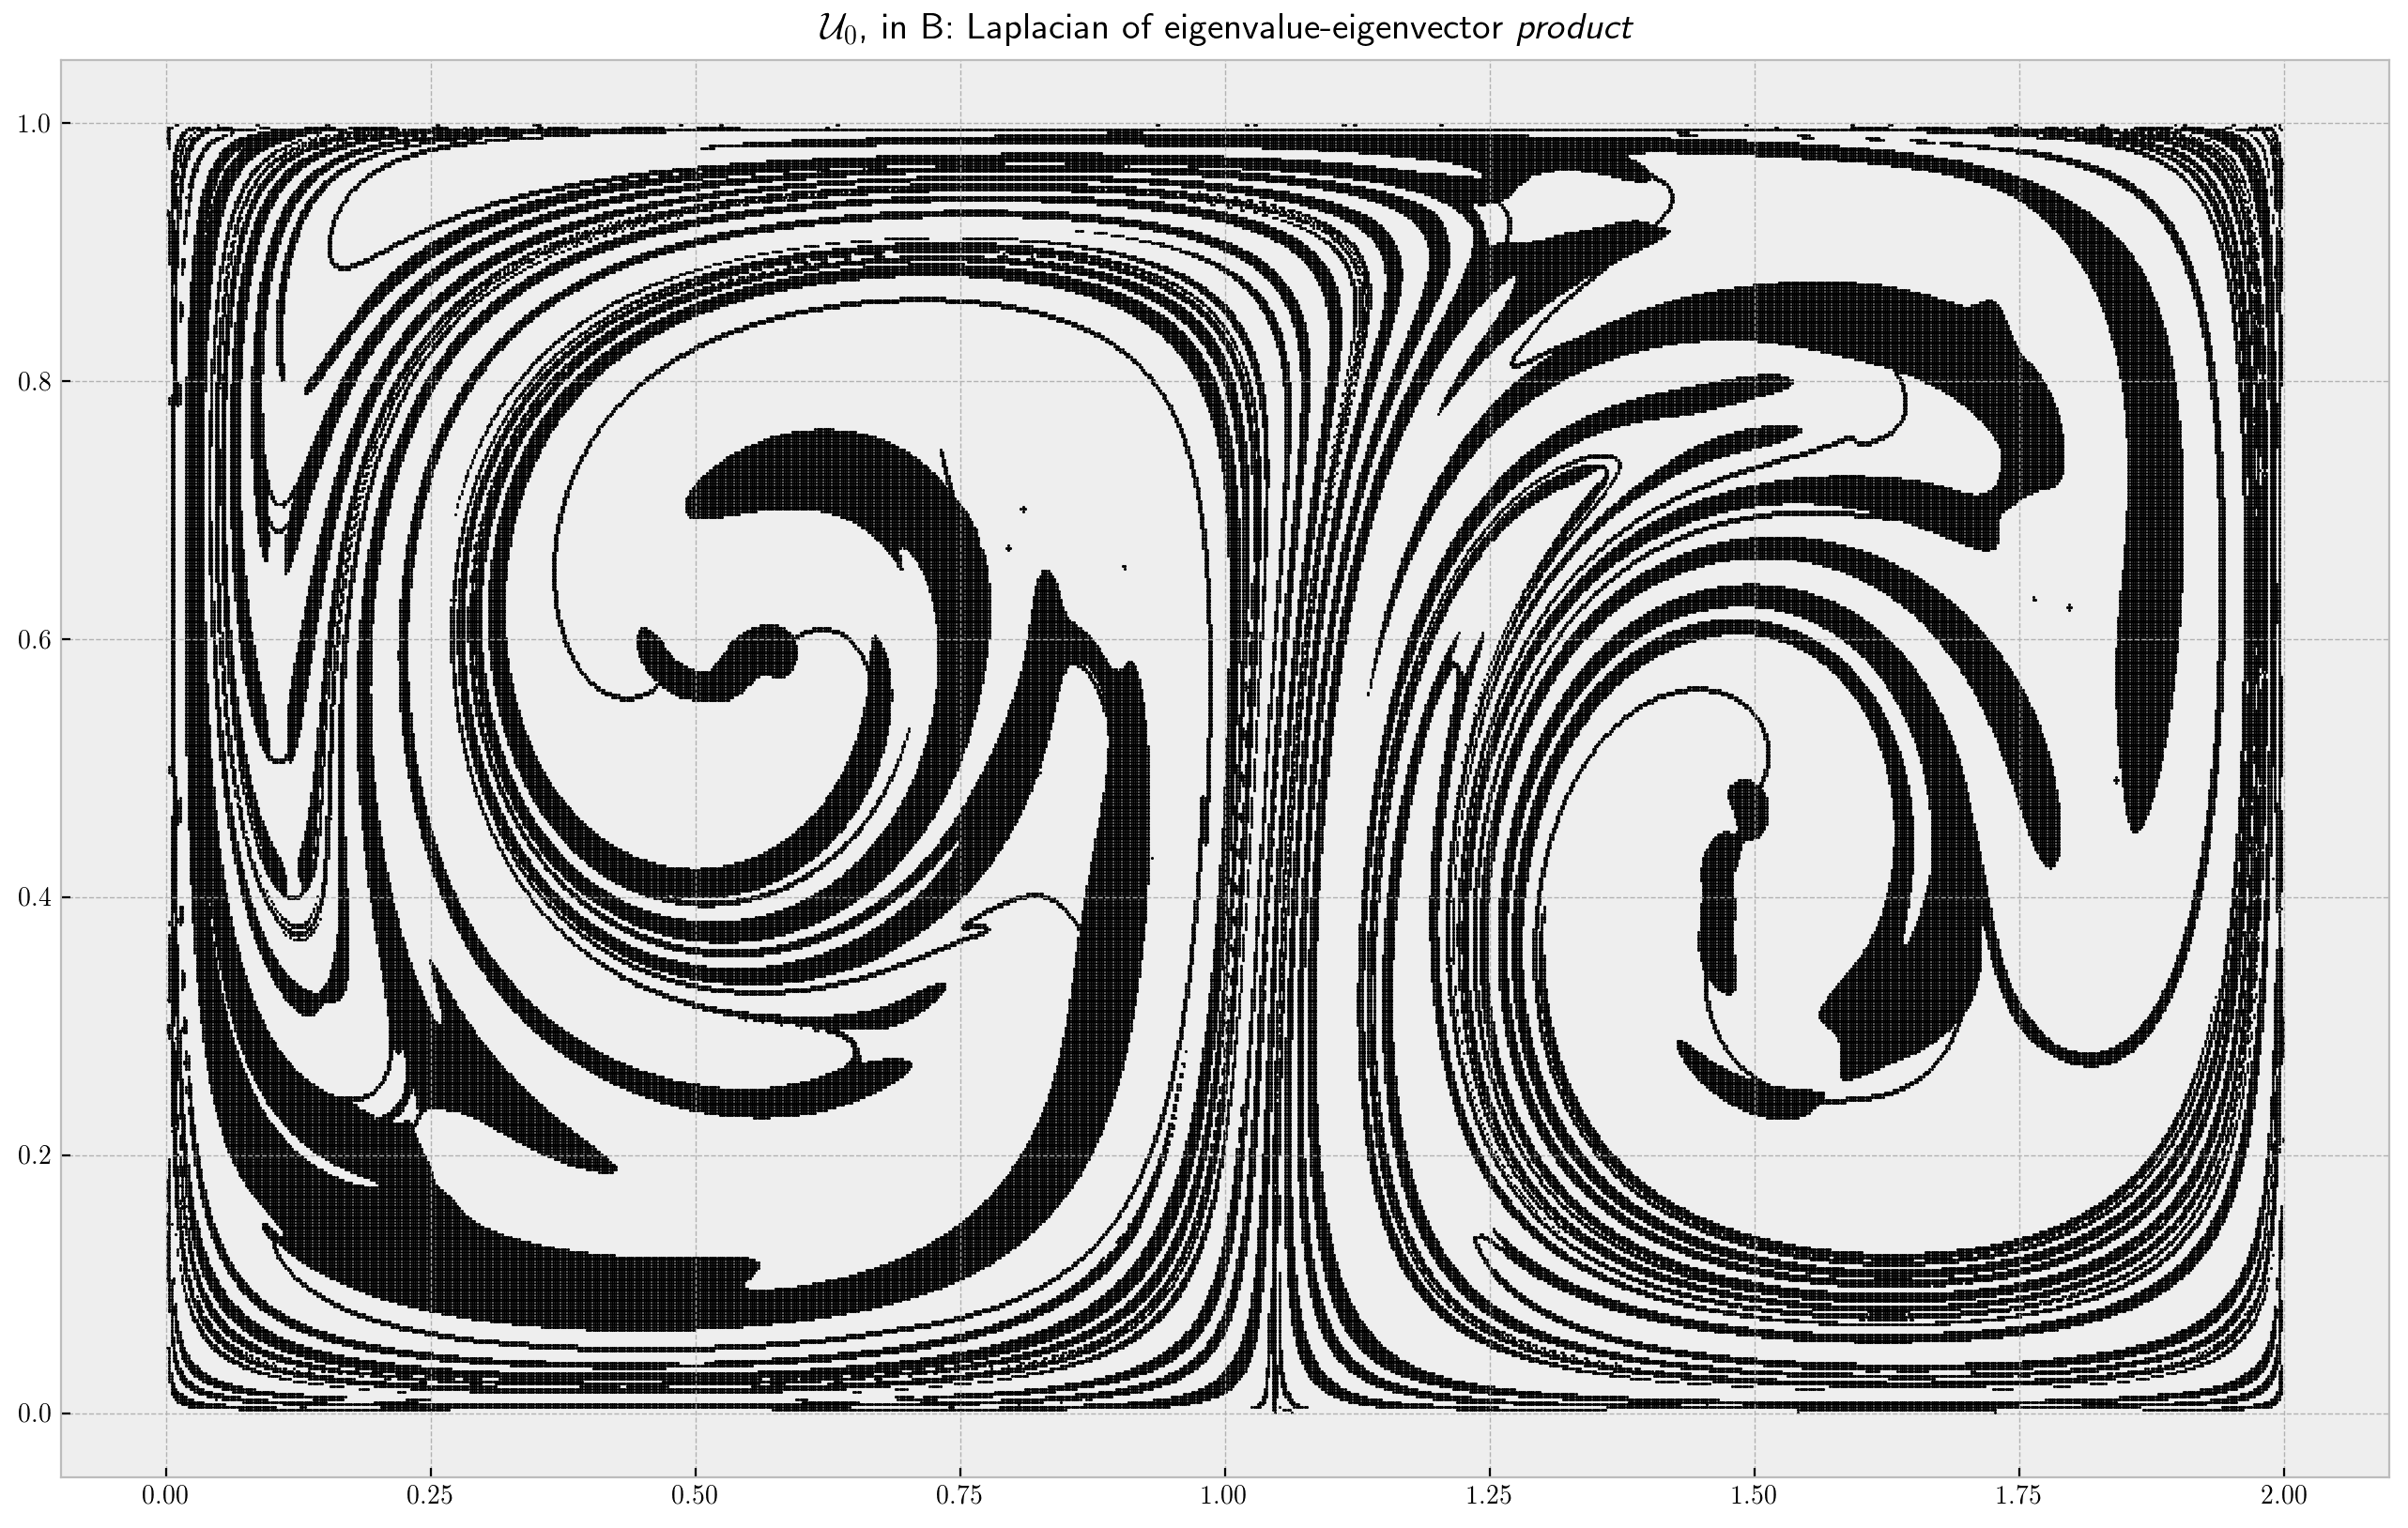

In [19]:
plt.figure(figsize = (16,10), dpi = 200)
plt.scatter(pos_init[0,np.logical_and(A_true,B_true2)], pos_init[1,np.logical_and(A_true,B_true2)], lw = 0, marker = '.', s = 5, color = 'k')
plt.title(r'$\mathcal{U}_{0}$, in B: Laplacian of eigenvalue-eigenvector \emph{product}')

# Step 6: Choose subset $\mathcal{G}_{0}$, as the intersection of $\mathcal{U}_{0}$ and four vertical and horizontal lines

In [25]:
mask = np.zeros((Nx, Ny), dtype = np.bool)

for i in range(1,5):
    mask[:, np.minimum(int(i*Ny/5), Ny - 1)] = True
    mask[np.minimum(int(i*Nx/5), Nx - 1), :] = True
    
one_mask_to_rule_them_all = np.logical_and(mask, np.logical_and(A_true, B_true))    

G_0 = pos_init[:, one_mask_to_rule_them_all]

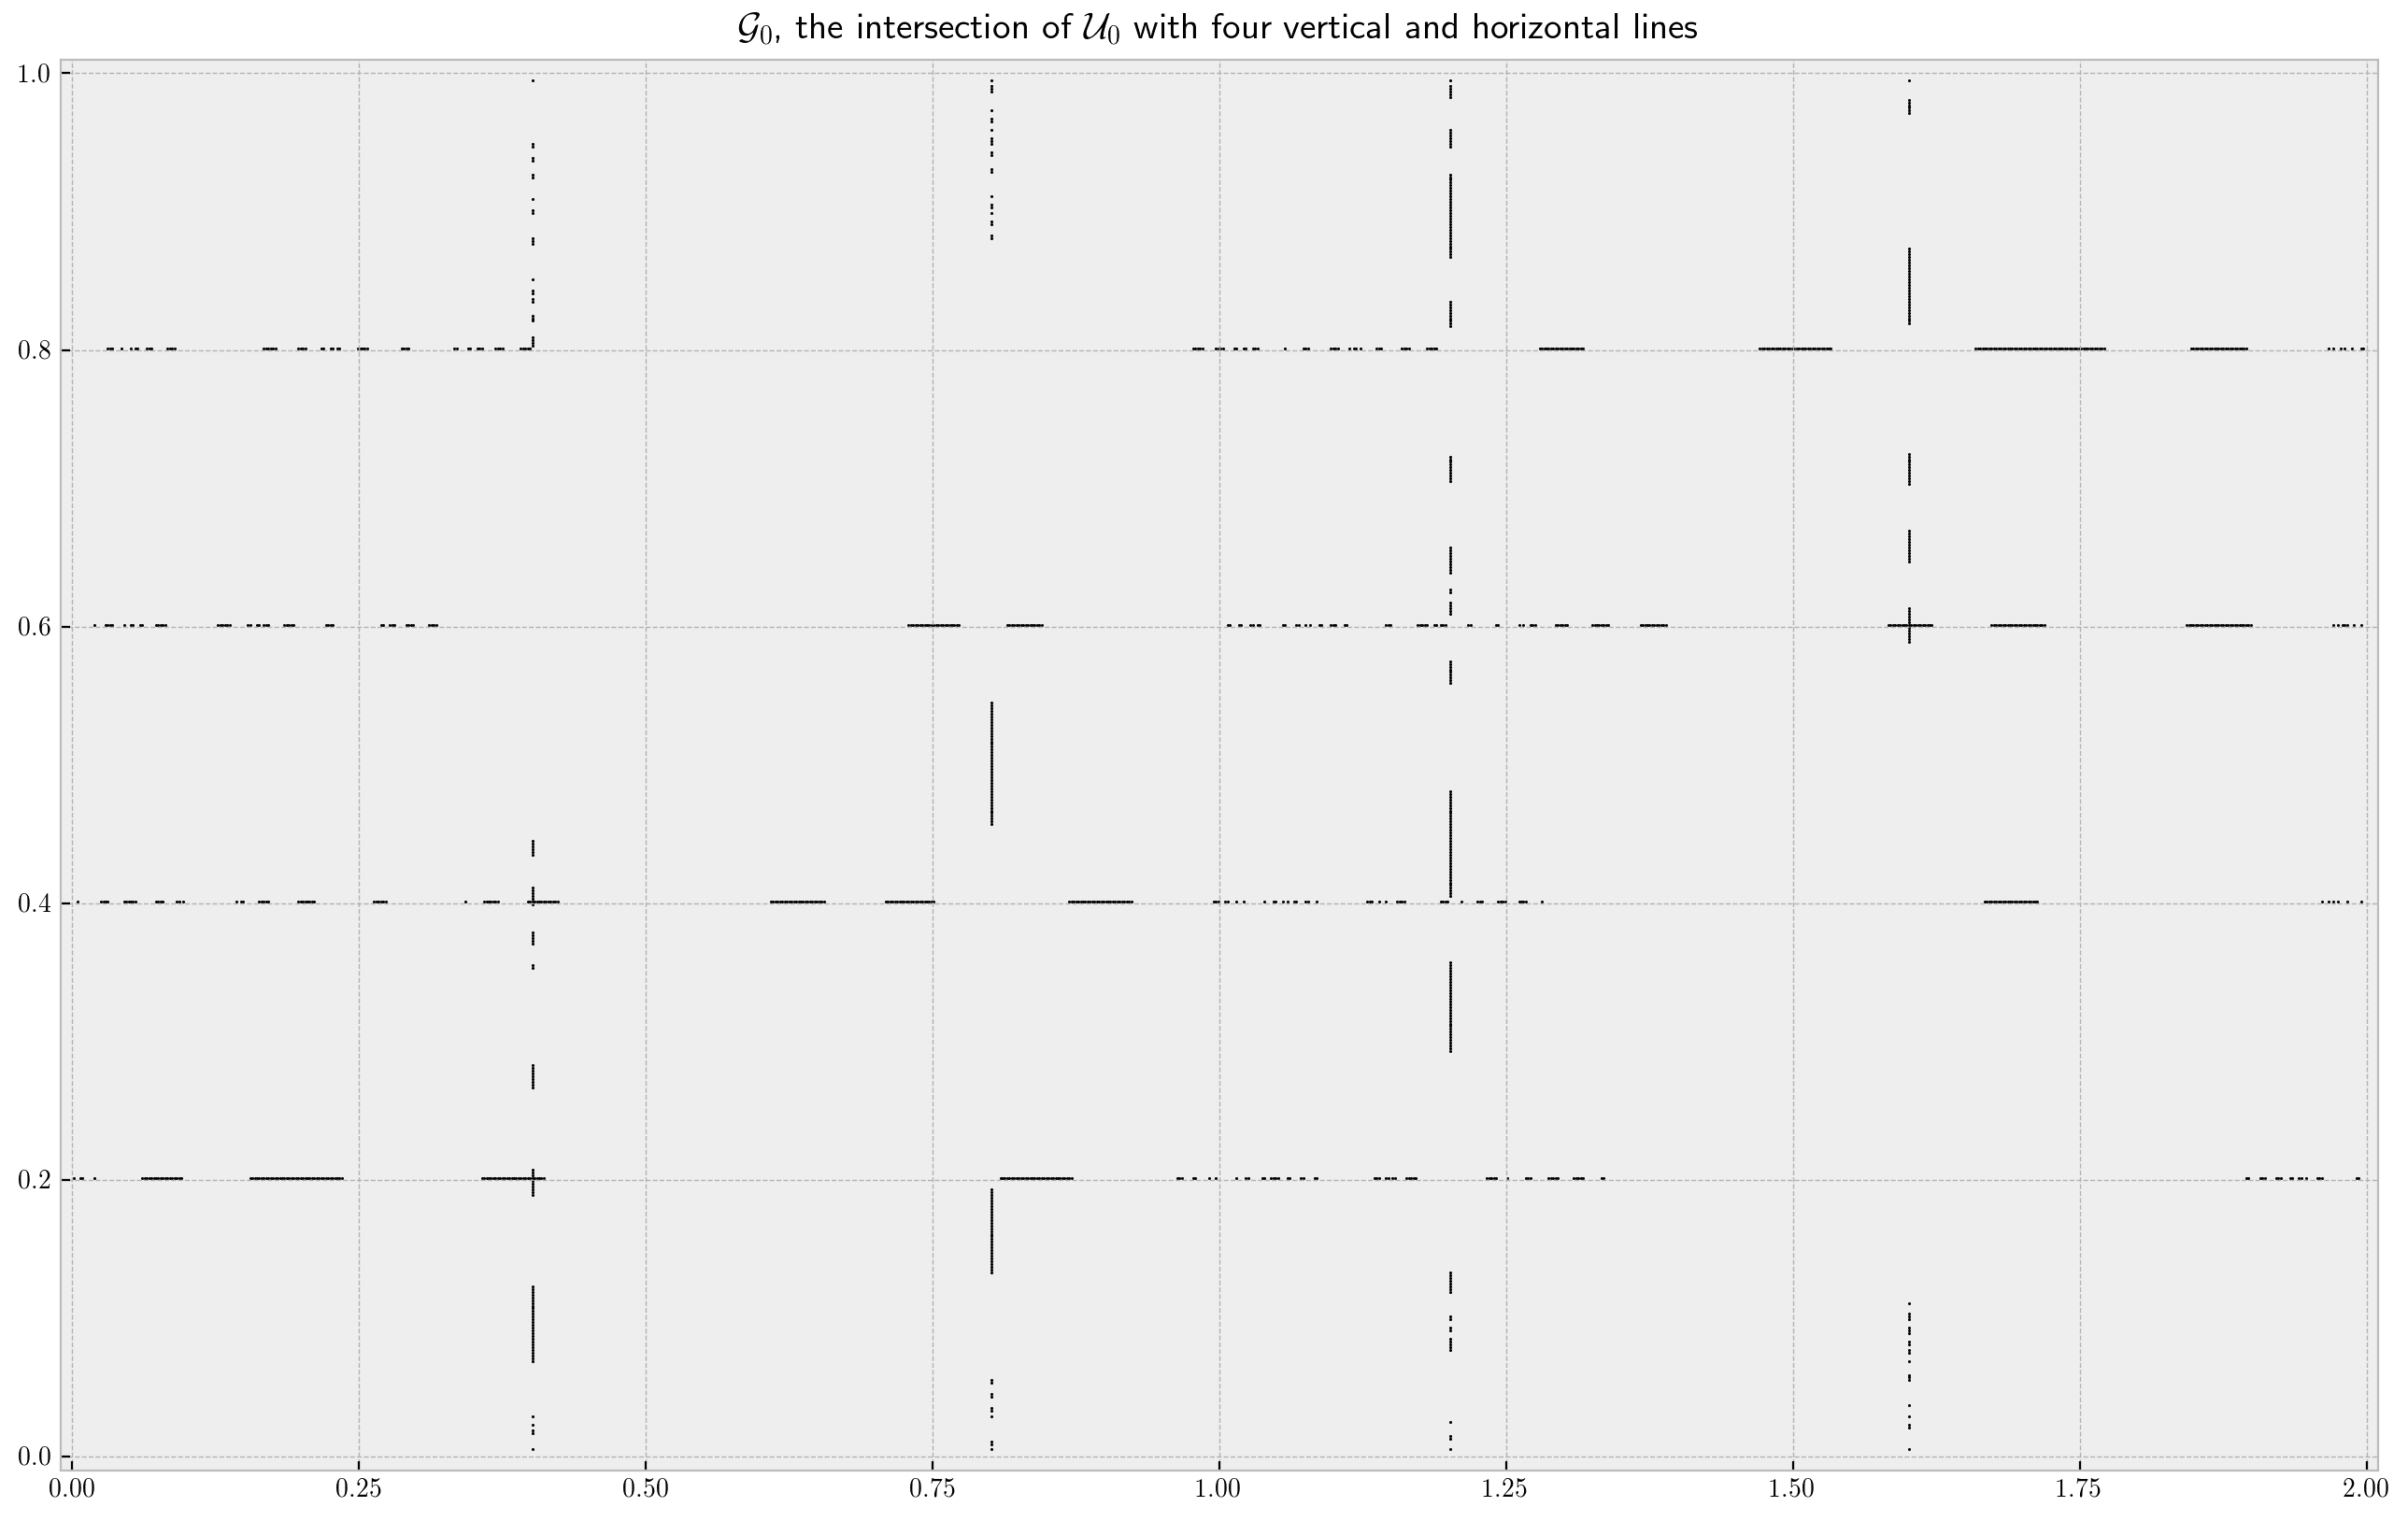

In [26]:
plt.figure(figsize = (16,10), dpi = 200)
plt.scatter(G_0[0], G_0[1], marker = '.', c = 'k', lw = 0, s = 5)
plt.xlim([-0.01, 2.01])
plt.ylim([-0.01, 1.01])
plt.title(r'$\mathcal{G}_{0}$, the intersection of $\mathcal{U}_{0}$ with four vertical and horizontal lines')

# Step 7: Define rescaled vector field from $\xi_{1}$ and advect the points in $\mathcal{G}_{0}$

## Using cubic splines:

In [22]:
lambda1_spline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evals[1,:,:].T)
lambda2_spline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evals[0,:,:].T)

xi1_x_spline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evecs[0,1,:,:].T)
xi1_y_spline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evecs[1,1,:,:].T)


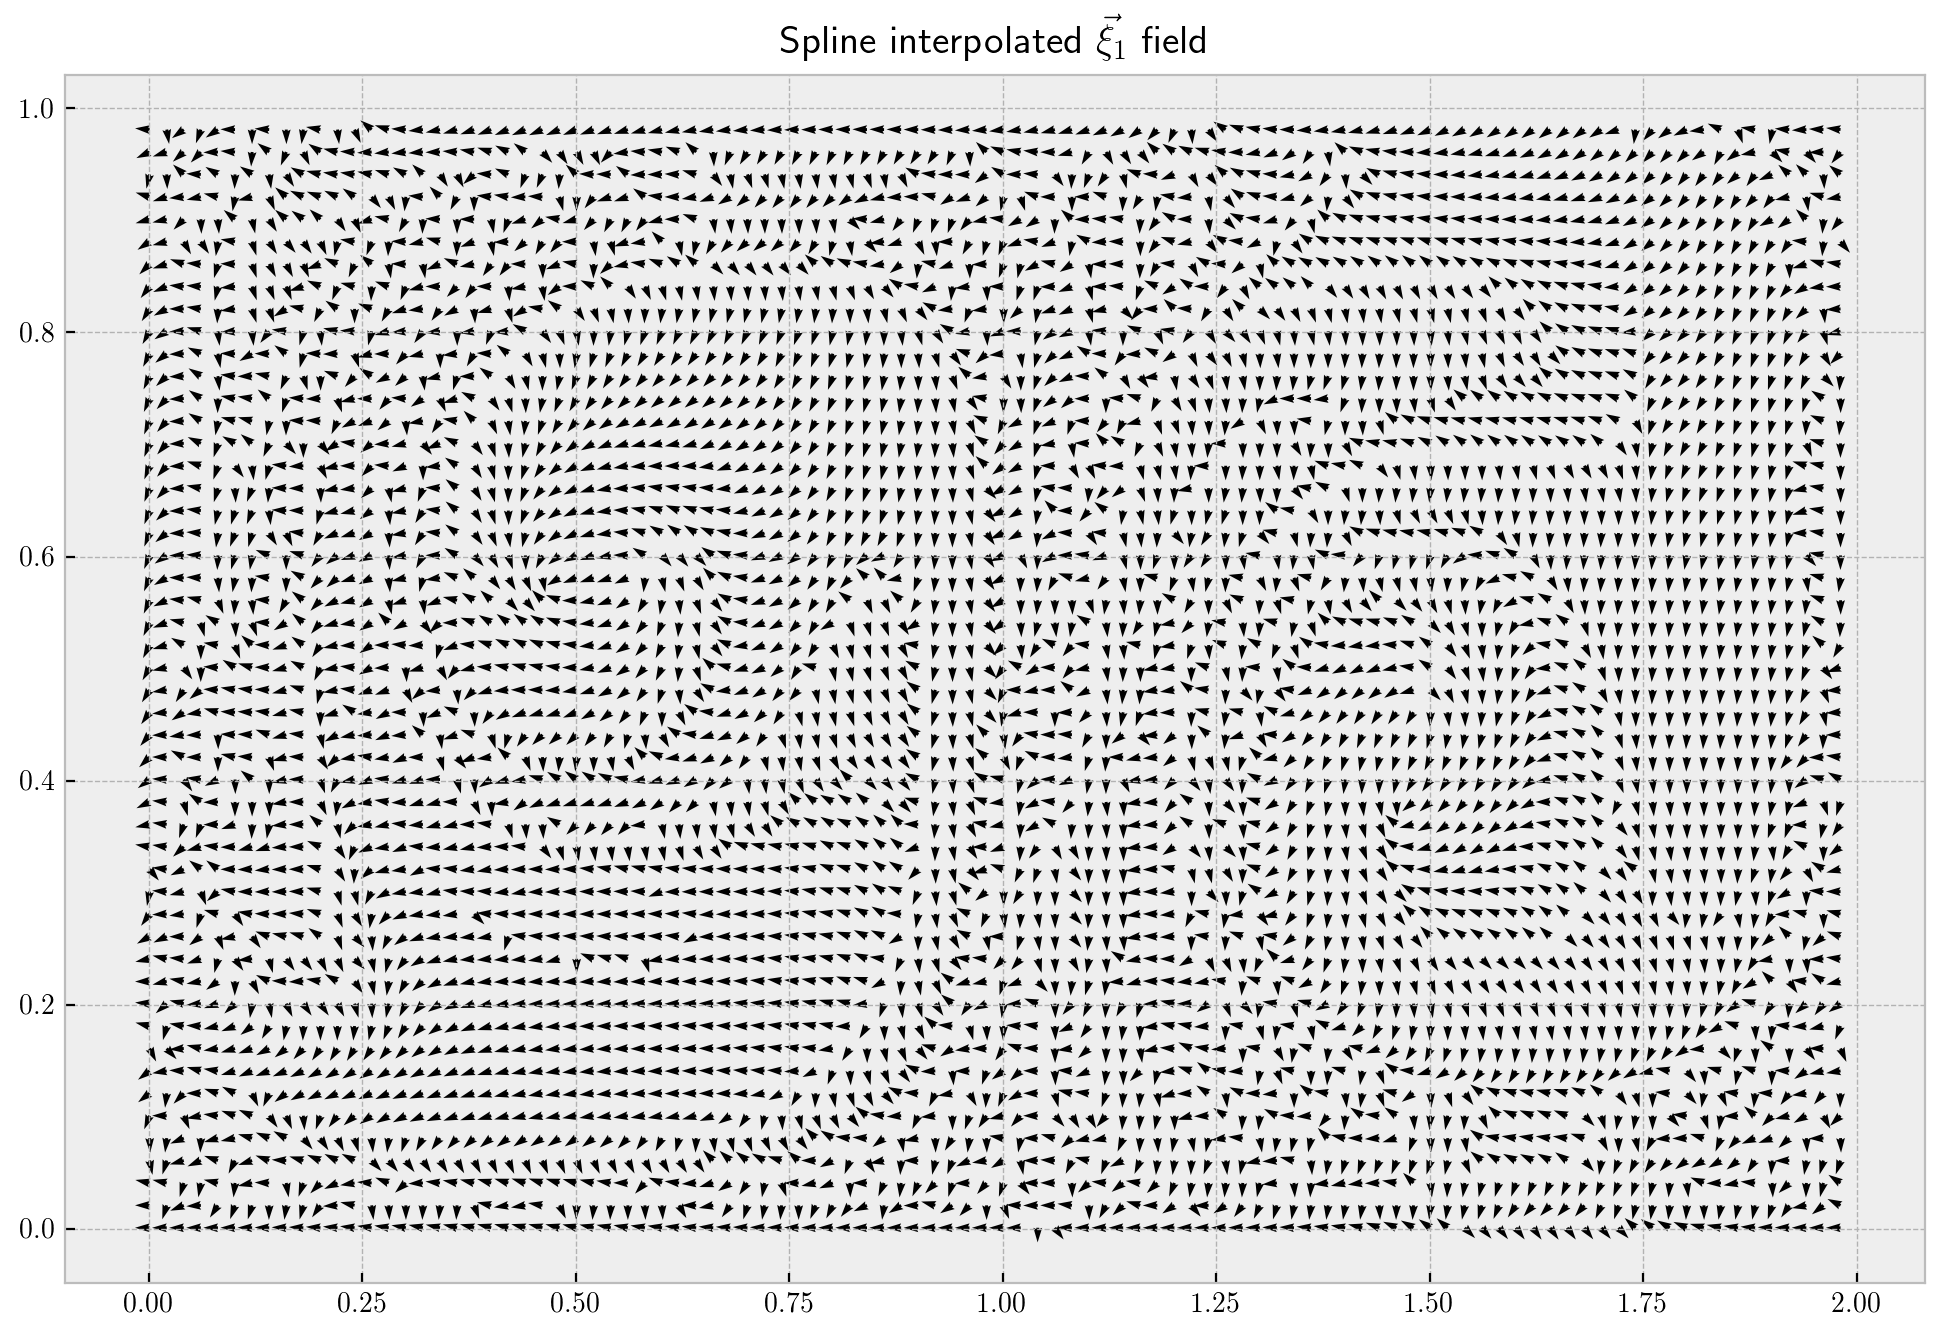

In [23]:
plt.figure(figsize = (12,8), dpi = 200)
plt.quiver(pos_init[0][::10,::10], pos_init[1][::10,::10], xi1_x_spline.ev(pos_init[1], pos_init[0])[::10,::10], xi1_y_spline.ev(pos_init[1], pos_init[0])[::10,::10])
plt.title(r'Spline interpolated $\vec{\xi}_{1}$ field')

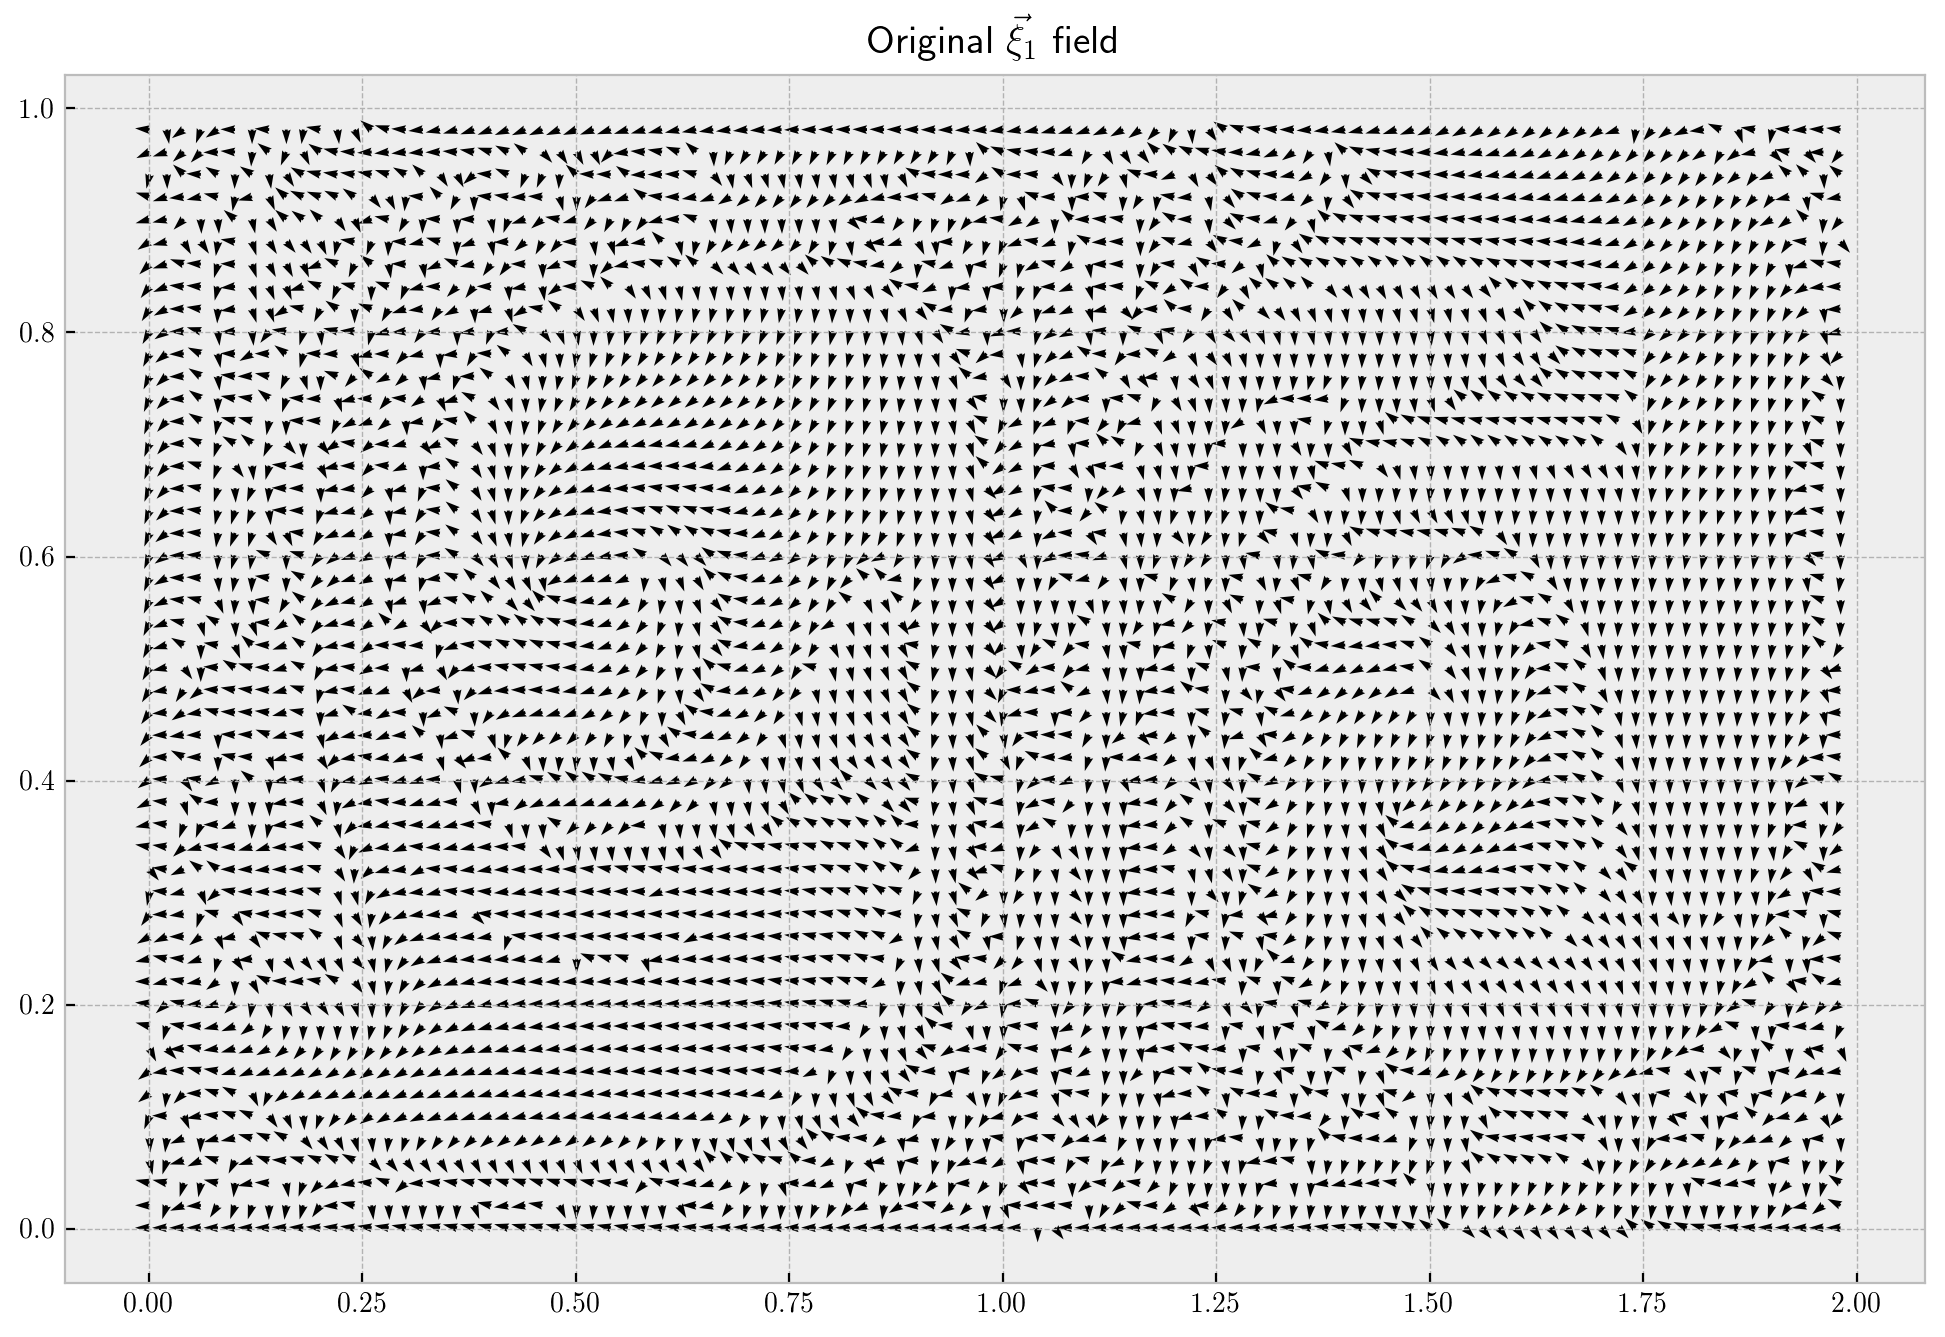

In [24]:
plt.figure(figsize = (12,8), dpi = 200)
plt.quiver(pos_init[0][::10,::10], pos_init[1][::10,::10], evecs[0,1][::10,::10], evecs[1,1][::10,::10])
plt.title(r'Original $\vec{\xi}_{1}$ field')

In [27]:
class Rescaled():
    def __init__(self, lambda1_spline, lambda2_spline, xi1_x_spline, xi1_y_spline):
        self.lambda1_spline = lambda1_spline
        self.lambda2_spline = lambda2_spline
        self.xi1_x_spline   = xi1_x_spline
        self.xi1_y_spline   = xi1_y_spline
        self.f_old = None
        
    def __call__(self, t, x):
        lambda1 = self.lambda1_spline.ev(x[1], x[0])
        lambda2 = self.lambda2_spline.ev(x[1], x[0])
        alpha = ((lambda2 - lambda1)/(lambda2 + lambda1))**2
        xi1_x = self.xi1_x_spline.ev(x[1], x[0])
        xi1_y = self.xi1_y_spline.ev(x[1], x[0])
        
        f_new = alpha * np.array([xi1_x, xi1_y])
        
        #evec_x /= length
        #evec_y /= length
        
        if self.f_old is None:
            self.f_old = f_new
        
        sign = np.sign(np.dot(self.f_old, f_new))
        
        self.f_old = f_new
        
        
        #sign = np.sign(np.sum(self.f_old * alpha * np.array([evec_x, evec_y])))
            

        return sign * f_new

In [28]:
class InAB():
    def __init__(self, AB_spline):
        self.AB_spline = AB_spline
        
    def __call__(self, x):
        return np.greater(self.AB_spline.ev(x[1],x[0]), 0.5)
    
class InDomain():
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        
    def __call__(self, x):
        return np.logical_and(np.logical_and(np.less_equal(x[0], self.x_max), np.greater_equal(x[0], self.x_min)), np.logical_and(np.less_equal(x[1], self.y_max), np.greater_equal(x[1], self.y_min)))

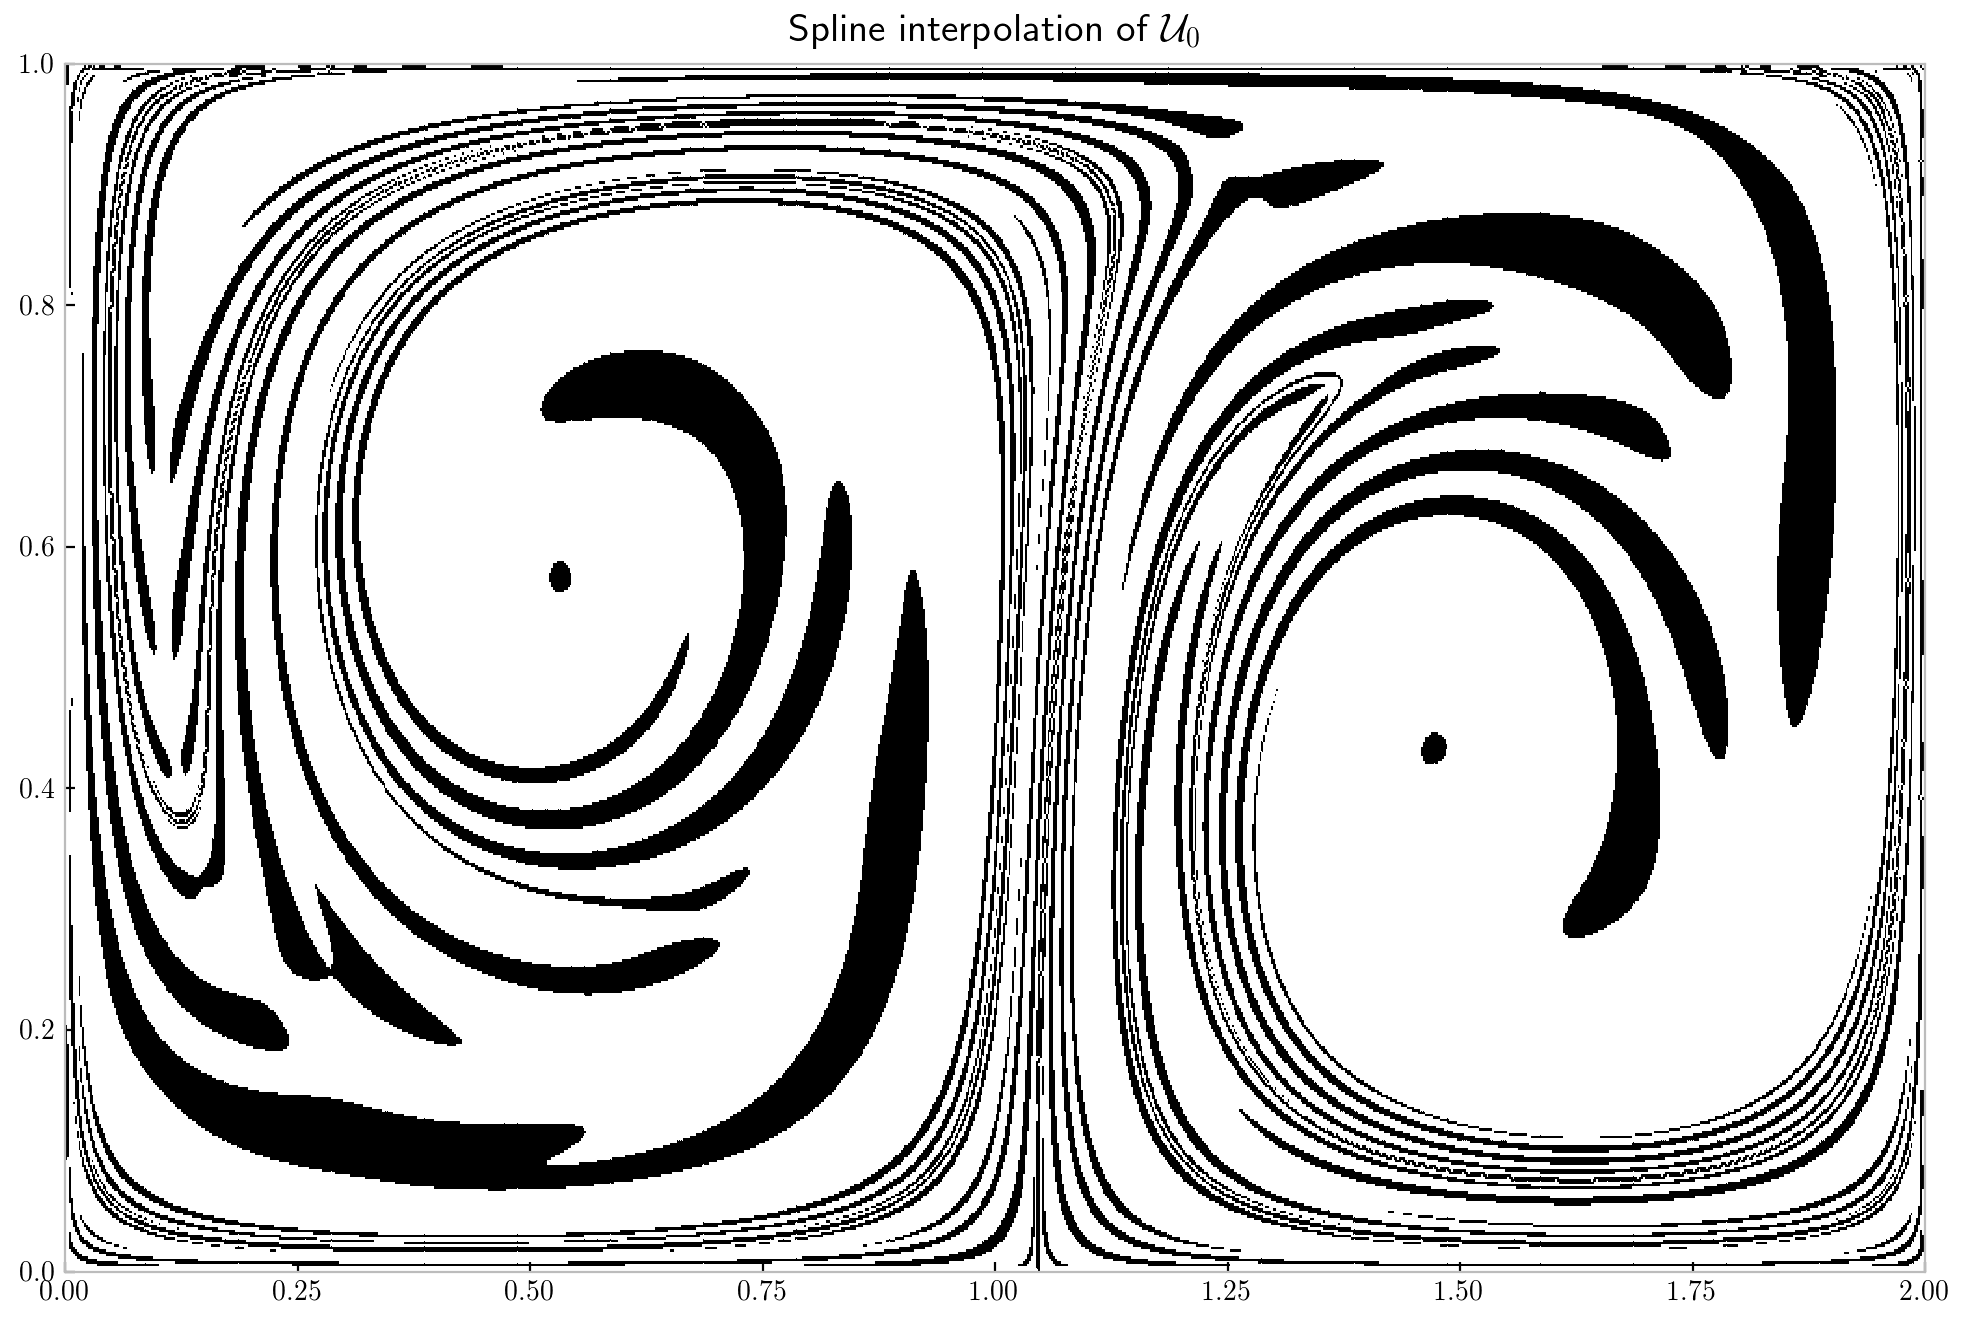

In [29]:
G = np.copy(G_0)

AB_spline = RectBivariateSpline(pos_init[1, 0, :], pos_init[0, :, 0], np.logical_and(A_true, B_true).T)

inAB = InAB(AB_spline)

inDomain = InDomain(x_min = 0, x_max = 2, y_min = 0, y_max = 1)

plt.figure(figsize = (12, 8), dpi = 200)
plt.pcolormesh(pos_init[0], pos_init[1], inAB(pos_init), cmap = 'gray_r')
plt.xlim(0,2)
plt.ylim(0,1)
plt.title(r'Spline interpolation of $\mathcal{U}_{0}$')

In [ ]:
np.sum(inDomain(pos_init))

In [30]:
class Strainline():
    def __init__(self,pos_init):
        self.pos = [pos_init.T]
        self.continious_failure = False
        self.is_long_enough = False
    #    self.is_strainline = True
    
    def __call__(self):
        return np.asarray(self.pos[-1])
    
    def has_failed_continuity(self):
        return self.continious_failure
    
    def failed_continuity(self):
        self.continious_failure = True
        
    def sufficient_length(self):
        self.is_long_enough = True
    
    #def is_not(self):
    #    self.is_strainline = False
    
    def is_strainline(self):
        return np.logical_and(self.is_long_enough, np.logical_not(self.continious_failure))
    
    def append(self, pos):
        self.pos.append(pos.T)
    
    def get_entire_trajectory():
        return np.asarray(self.pos)

In [31]:
f = Rescaled(lambda1_spline, lambda2_spline, xi1_x_spline, xi1_y_spline)

In [32]:
strainlines = [Strainline(G[:,j]) for j in range(np.size(G,1))]

max_iter = 10000
stride = 0.01
l_f_max = 0.2
l_min = 1


for count, strainline in enumerate(strainlines):
    f.f_old = None
    t = 0.
    i = 0
    L = 0.
    L_f = 0.
    while np.logical_and(np.logical_and(np.less(i, max_iter), inDomain(strainline())), np.logical_not(strainline.has_failed_continuity())):
        foo, tmp, stride = integrator(t, strainline(), stride, f)
        if np.greater(foo, t):
            L += np.sqrt((strainline()[0] - tmp[0])**2 + (strainline()[1] - tmp[1])**2)
            if np.logical_not(inAB(tmp)):
                #prev = strainline()
                L_f += np.sqrt((strainline()[0] - tmp[0])**2 + (strainline()[1] - tmp[1])**2)
            else:
                L_f = 0.
            strainline.append(tmp)
            if np.greater(L_f, l_f_max):
                strainline.failed_continuity()
            i += 1
    if np.greater(L, l_min):
        strainline.sufficient_length()
    if np.logical_not(np.mod(count, 100)):
        print('Finished integrating strainline candidate {} of {}'.format(count, np.size(strainlines)))
                
        
    

#a = strainlines[0]

#a.append(np.asarray([-1, -1]))
#b = a()
#b

Finished integrating strainline candidate 0 of 1357
Finished integrating strainline candidate 100 of 1357
Finished integrating strainline candidate 200 of 1357
Finished integrating strainline candidate 300 of 1357
Finished integrating strainline candidate 400 of 1357
Finished integrating strainline candidate 500 of 1357
Finished integrating strainline candidate 600 of 1357
Finished integrating strainline candidate 700 of 1357
Finished integrating strainline candidate 800 of 1357
Finished integrating strainline candidate 900 of 1357
Finished integrating strainline candidate 1000 of 1357
Finished integrating strainline candidate 1100 of 1357
Finished integrating strainline candidate 1200 of 1357
Finished integrating strainline candidate 1300 of 1357


In [33]:
# plt.figure(figsize = (10, 8), dpi = 200)

real_candidates = []

for strainline in strainlines:
    if np.logical_and(strainline.is_strainline, np.logical_and(strainline.is_long_enough, np.logical_not(strainline.continious_failure))):
        real_candidates.append(strainline)
        
#real_candidates[0].pos

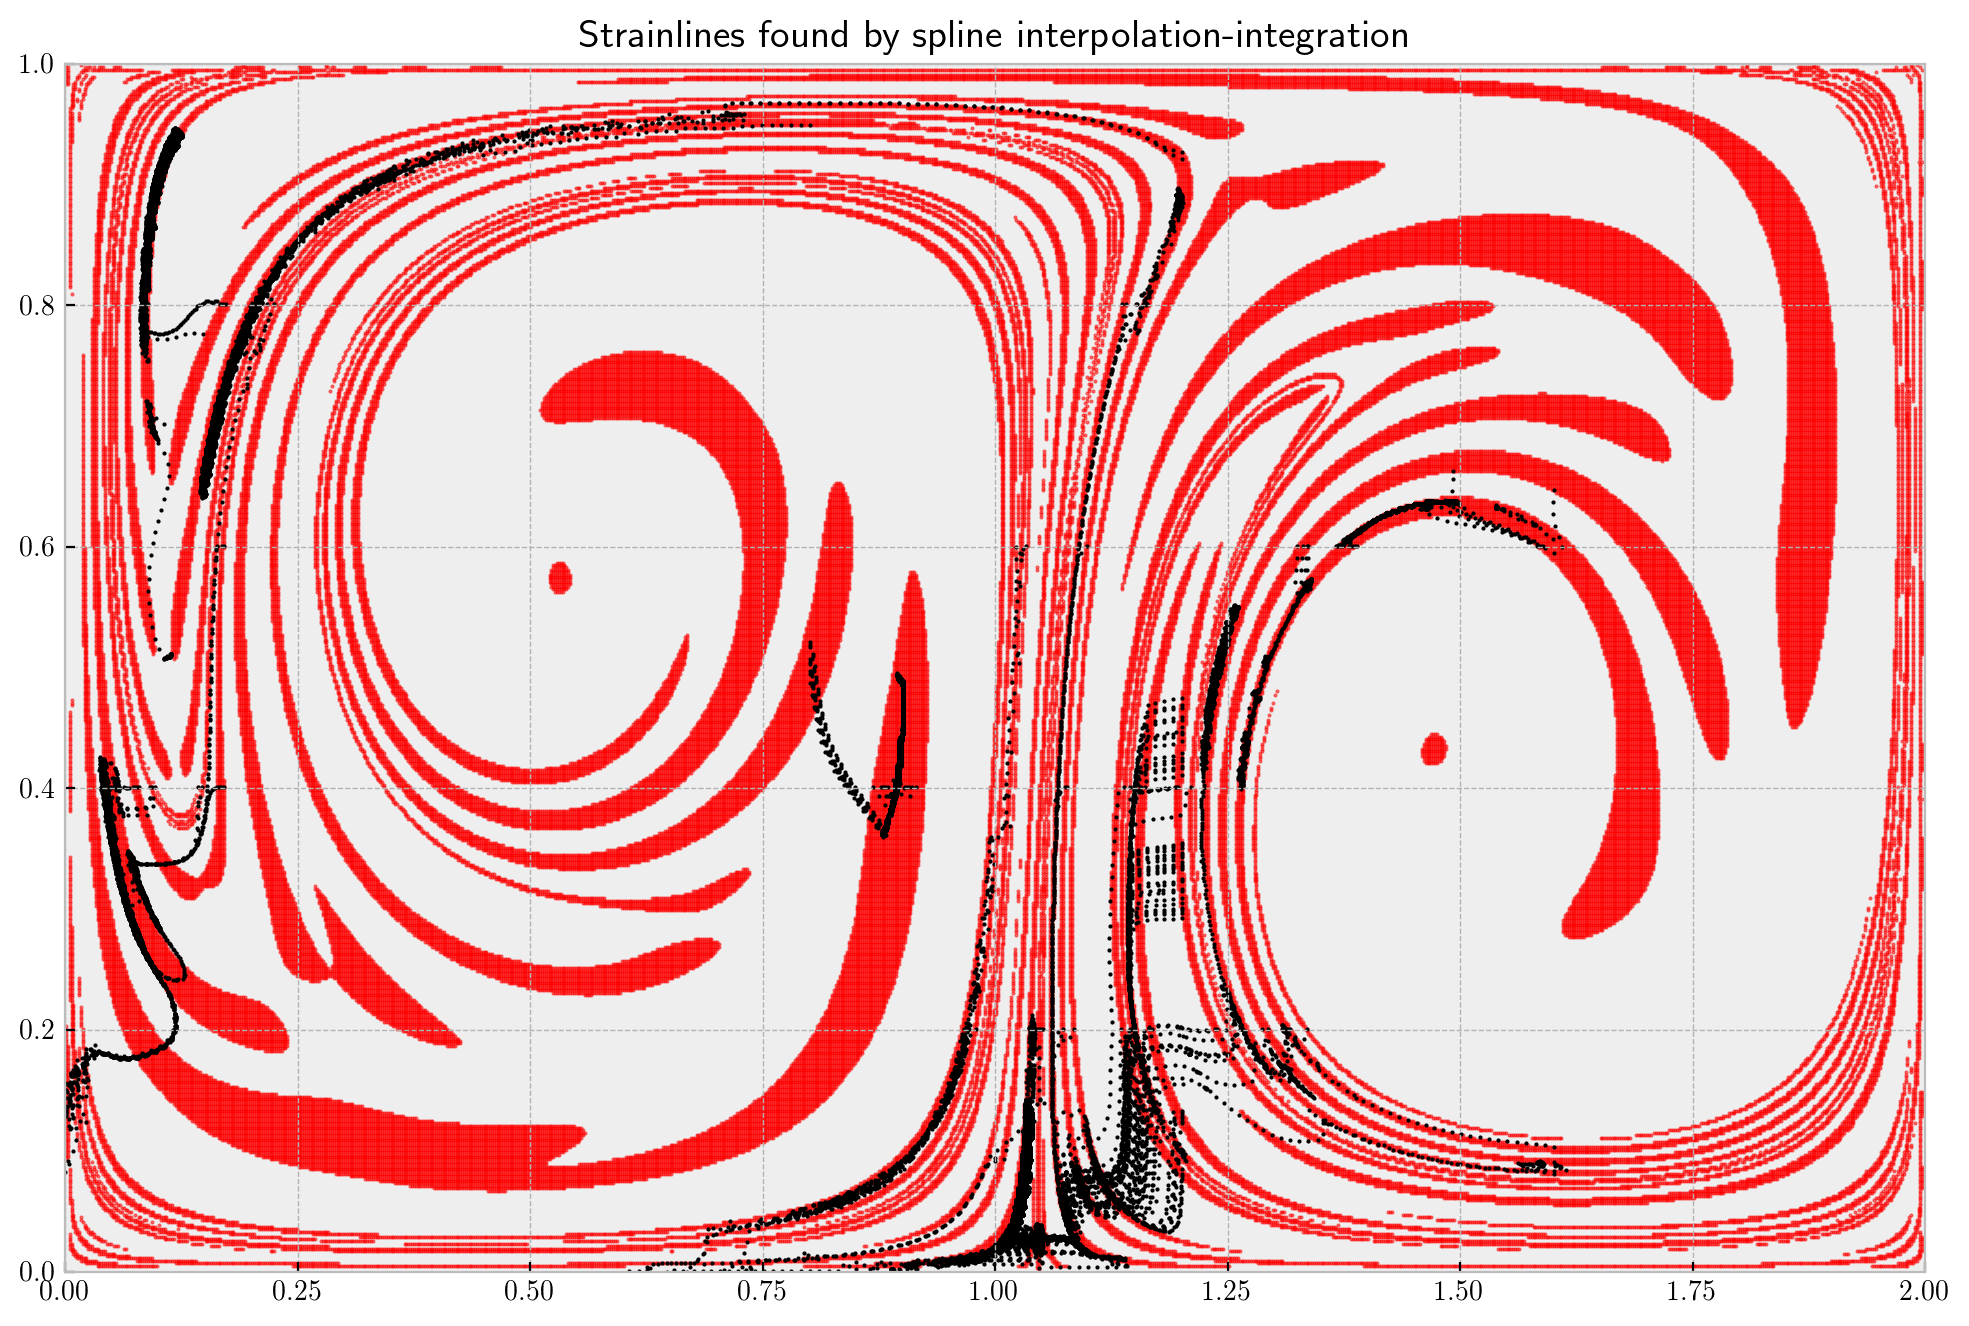

In [37]:
plt.figure(figsize = (12, 8), dpi = 200)
plt.scatter(pos_init[0,np.logical_and(A_true,B_true)], pos_init[1,np.logical_and(A_true,B_true)], s = 1, color = 'r', alpha = 0.5)
for real_candidate in real_candidates:
    plt.scatter(np.asarray(real_candidate.pos)[:,0], np.asarray(real_candidate.pos)[:,1], color = 'k', s = 1)

plt.xlim(0, 2)
plt.ylim(0, 1)
plt.title('Strainlines found by spline interpolation-integration')

In [ ]:
T = 10.
t = 0.
h = 0.1

foo = Rescaled(lambda1_spline, lambda2_spline, xi1_x_x_spline, xi1_y_spline)

G = np.copy(G_0)


ts = np.ones(np.shape(G)[1]) * t
hs = np.ones(np.shape(G)[1]) * h



traj = []

integration_mask = np.less(ts, T)

#for i in range(int((T-t)/h)):
while np.any(integration_mask):
    traj.append(G)
    foo.f_old = foo(ts[integration_mask], G[:,integration_mask])
    hs[integration_mask] = np.minimum(hs[integration_mask], T - ts[integration_mask])
    ts[integration_mask], G[:, integration_mask], hs[integration_mask] = integrator(ts[integration_mask], G[:, integration_mask], hs[integration_mask], foo, tol, tol)
    #G[:, integration_mask] = tm
    integration_mask = np.less(ts, T)
    #traj.append(G)
    #print(np.sum(integration_mask))

In [ ]:
np.sum(integration_mask)

In [ ]:
traj[-1]

In [ ]:
plt.figure(figsize = (8,6), dpi = 200)
t2 = np.asarray(traj)

#plt.spy(B_true[:, ::-1].T)
#plt.spy(one_mask_to_rule_them_all[:,::-1].T)
for j in range(np.shape(t2)[2]):
    plt.plot(t2[:,0,j], t2[:,1,j], c = 'k', lw = 1, alpha = 0.5)

plt.xlim([-0.1, 2.1])
plt.ylim([-0.1, 1.1])

plt.tight_layout()

In [ ]:
one_mask_to_rule_them_all.shape

## Using special-purpose linear interpolation:

In [ ]:
class LinearSpecial():
    def __init__(self, xc, yc, xi):
        self.xc = xc
        self.yc = yc
        self.dx = xc[-1]- xc[-2]
        self.dy = yc[-1] - yc[-2]
        self.xi = xi
        self.Nx = np.size(xc)
        self.Ny = np.size(yc)
        self.fold = None
        #print(np.shape(xi))
        #print(np.shape(self.xi))
        
    def __call__(self, t, x):
        # Calculate indices for lower left corner in cell:
        i = int(x[0]/self.dx)
        j = int(x[1]/self.dy)
        
        # If outside the domain, move inside:
        i = np.minimum(i, Nx - 2)
        j = np.minimum(j, Ny - 2)
        
        # Use the lower left corner as reference, calculate 
        # the rotation of the other vectors, and rotate by
        # 180 degrees if necessary (due to oriental 
        # discontinuity)
        subxi = np.zeros((2, 2, 2))
        subxi[:] = self.xi[:, i:i+2, j:j+2]
        
        #print(np.shape(self.xi[:, i:i+2, j:j+2]))
        
        for n in range(2):
            for m in range(2):
                if np.logical_and(np.equal(n,m), np.equal(n,0)):
                    pass
                else:
                    # Flip direction if dot product is negative
                    subxi[:,n,m] = np.sign(np.dot(subxi[:,0,0], subxi[:,n,m])) * subxi[:,n,m]
                    
        # Linear interpolarion:
        W = np.zeros((1,2,2))
        W[0,0,0] = self.xc[i+1] - x[0]
        W[0,0,1] = 1 - W[0,0,0]
        W[0,1,0] = self.yc[j+1] - x[1]
        W[0,1,1] = 1 - W[0,1,0]
        
        V = np.sum(W * subxi, axis = (1,2))
        
        V /= np.sqrt(V[0]**2 + V[1]**2)
        
        # Check orientation against previous vector:
        if self.fold is None:
            return V
        else:
            # If dot product is negative, flip sign:
            return np.sign(np.dot(self.fold, V)) * V

In [ ]:
bar = LinearSpecial(pos_init[0,:,0], pos_init[1,0,:], evecs[:,1,:,:])

# Loop over all initial conditions
# If (A and B), check if point 
# corresponds to a local max.
# of lambda_2 (largest eigval)

r = 0.01

LCSs = []

#progressbar = FloatProgress(min = 0, max = Nx)
#display(progressbar)

for i in range(Nx):
    if (not np.mod(i+1,100)):
        print('{}th of {} rows'.format(i, Nx))
    #progressbar.value = i
    for j in range(Ny):
        if np.logical_and(A_true, B_true)[i,j]:
            
            # Re-initialize the derivative function:
            bar.fold = None
            
            dists = np.sum((pos_init[:,i,j].reshape(2,1,1) - pos_init)**2, axis = 0)
            if np.less(evals[0,i,j], np.amax(evals[0,:,:][np.less(dists, r)])):
                pass
            else:
                T = 5
                t = 0
                h = 0.0001
                Nt = int((T-t)/h)
                
                l_min = 1
                l = 0
                
                l_filter = 0.2
                l_out = 0
                
                xs = np.zeros((2, Nt))
                xs[:,0] = pos_init[:, i, j]
                
                for n in range(1, Nt):
                    bar.fold = bar(t, xs[:, n-1])
                    t, tmp, h = rk4(t, xs[:, n-1], h, bar)
                    xs[:, n] = tmp
                    if np.greater(ABspline.ev(tmp[1], tmp[0]), 1e-2):
                        l_out += np.sqrt((xs[0,n] - xs[0,n-1])**2 + (xs[1,n] - xs[1,n-1])**2)
                    else:
                        l_out = 0
                    
                    if l_out > l_filter or np.logical_or(np.logical_or(np.less(xs[0,n], 0.), np.greater(xs[0,n], 2.)), np.logical_or(np.less(xs[1,n], 0.), np.greater(xs[1,n], 1.))):
                        break
                    l += np.sqrt((xs[0,n] - xs[0,n-1])**2 + (xs[1,n] - xs[1,n-1])**2)
                
                if np.greater(l, l_min):
                    LCSs.append(xs[:,:n])
                    print(len(LCSs))
                #print(i*Nx + j)

In [ ]:
ABspline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], np.logical_and(A_true, B_true).T)
ABspline.ev(pos_init[1,0,0], pos_init[0,0,0])

In [ ]:
#bar = LinearSpecial(pos_init[0,:,0], pos_init[1,0,:], evecs[:,1,:,:])

# Loop over all initial conditions
# If (A and B), check if point 
# corresponds to a local max.
# of lambda_2 (largest eigval)

#r = 0.01

#LCSs = []

#eigenvals_in_G_0 = evals[0,one_mask_to_rule_them_all]

#progressbar = FloatProgress(min = 0, max = Nx)
#display(progressbar)

#for i in range(G_0.shape[1]):
    #progressbar.value = i
    #for j in range(Ny):
        #if one_mask_to_rule_them_all[i,j]:
            
    # Re-initialize the derivative function:
#    bar.fold = None
            
#    dists = np.sum((G_0[:,i].reshape(2,1,1) - pos_init)**2, axis = 0)
#    if np.less(eigenvals_in_G_0[i], np.amax(evals[0,:,:][np.less(dists, r)])):
        #print(i)
#        pass
        
#    else:
#        T = 5
#        t = 0
#        h = 0.0001
#        Nt = int((T-t)/h)
                
#        xs = np.zeros((2, Nt))
#        xs[:,0] = G_0[:,i]
                
#        for n in range(1, Nt):
#            bar.fold = bar(t, xs[:, n-1])
#            t, tmp, h = rk4(t, xs[:, n-1], h, bar)
#            xs[:, n] = tmp
#            if np.logical_or(np.logical_or(np.less(xs[0,n], 0.), np.greater(xs[0,n], 2.)), np.logical_or(np.less(xs[1,n], 0.), np.greater(xs[1,n], 1.))):
#                break
                
#        LCSs.append(xs[:,:n])
#        print(len(LCSs))
        #print(i*Nx + j)

In [ ]:
np.amax(evals[0,:,:][dists < r])

In [ ]:
plt.figure(figsize = (16, 10))

for i in range(len(LCSs)):
    plt.plot(LCSs[i][0,:], LCSs[i][1,:], c = 'k', lw = 1)
    
plt.xlim([-0.1, 2.1])
plt.ylim([-0.1, 1.1])

plt.tight_layout()

In [ ]:
plt.figure(figsize = (16,10), dpi = 200)
plt.pcolormesh(pos_init[0], pos_init[1], np.log(evals[1] + 1))

In [ ]:
plt.figure(figsize = (16, 10), dpi = 200)
plt.pcolormesh(pos_init[0], pos_init[1], np.log(smallest_eval_spline.ev(pos_init[1], pos_init[0]) + 1) )

In [ ]:
np.shape(G_0)

In [ ]:
plt.figure(figsize=(12,8), dpi = 200)
plt.quiver(pos_init[0], pos_init[1], evecs[0,0,:,:], evecs[1,0,:,:])
plt.title('Largest')

In [ ]:
plt.figure(figsize = (12,8), dpi = 200)
plt.quiver(pos_init[0], pos_init[1], evecs[0,1,:,:], evecs[1,1,:,:])
plt.title('Largest')